In [9]:
import os, sys

current_dir = os.getcwd()

target_folder = 'polygraphs'

target_path = current_dir[:current_dir.index(target_folder) + len(target_folder)]
sys.path.append(target_path)

In [1]:
from polygraphs.analysis import Processor
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
processor = Processor(["~/polygraphs-cache/results/"], config_check=False)
processor.add_config("reliability")
print(len(processor.graphs), len(processor.beliefs), len(processor.sims))
print(len(processor.beliefs.graphs[59]), len(processor.graphs[0].nodes), )

60 60 60
13032 13032


In [3]:
processor.graphs[0].pg['ndata']

{'logits': tensor([0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0040]), 'reliability': tensor([1., 1., 1.,  ..., 1., 0., 0.]), 'beliefs': tensor([0.9472, 0.2477, 0.5298,  ..., 0.6879, 0.3488, 0.8740])}

In [4]:
# picking a graph from the available graphs using indexing
graph = processor.graphs[0]

In [5]:
G = nx.read_gml("/Users/prudhvivuda/polygraphs-cache/francisbacon.gml", destringizer=int)
print(len(G))
print(G.nodes[8186])

13032
{'name': 'Sir Thomas Skipwith', 'original_id': 10011164}


## Applying Label Propagation

In [6]:
# Apply Label Propagation Algorithm
lp_communities = nx.algorithms.community.label_propagation_communities(graph)

# Convert generator output to dictionary: {node: community_id}
community_mapping = {}
for community_id, nodes in enumerate(lp_communities):
    for node in nodes:
        community_mapping[node] = community_id

In [7]:
# Convert community mapping to a DataFrame
lp_community_df = pd.DataFrame.from_dict(community_mapping, orient="index", columns=["lp_community_id"])
lp_community_df.reset_index(inplace=True)
lp_community_df.rename(columns={"index": "node"}, inplace=True)

lp_community_df.to_csv("label_propagation_community_assignments1.csv", index=False)

 INFO matplotlib.category> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 INFO matplotlib.category> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_93391/2156457219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")


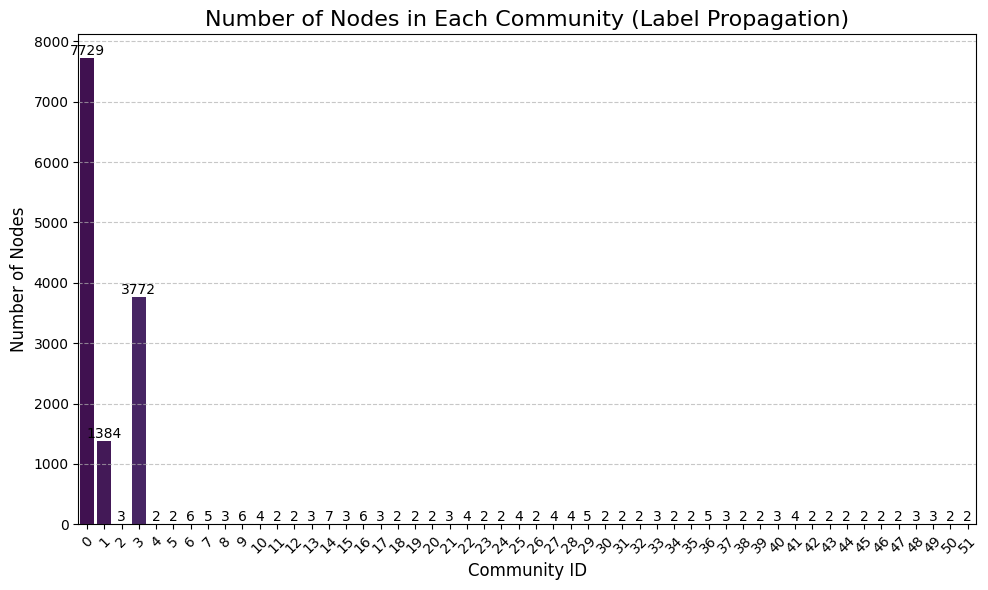

In [8]:
# Count the number of nodes in each community
community_sizes = lp_community_df["lp_community_id"].value_counts().sort_index()

# Plot a histogram of community sizes
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")

# Add counts on top of each bar
for bar, count in zip(barplot.patches, community_sizes.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Position the text
             str(count), ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Number of Nodes in Each Community (Label Propagation)", fontsize=16)
plt.xlabel("Community ID", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()

plt.show()


In [10]:
lp_community_df

,node,lp_community_id
0,0,0
1,1,0
2,2,0
3,3,0
4,5,0
...,...,...
13027,12917,49
13028,12984,50
13029,12950,50
13030,12968,51


In [12]:
# Compute the count of nodes in each lp_community_id
community_counts = lp_community_df['lp_community_id'].value_counts()

# Define threshold (1% of total nodes)
threshold = int(0.01 * len(lp_community_df))  # 1% of 13032 = 131

# Filter communities that meet the threshold
interested_communities = community_counts[community_counts >= threshold].index

interested_communities

Index([0, 3, 1], dtype='int64', name='lp_community_id')

In [13]:
# Create filtered DataFrame
lp_communities_df = lp_community_df[lp_community_df['lp_community_id'].isin(interested_communities)]

# Print the number of communities retained
print(f"Number of communities after filtering: {lp_communities_df['lp_community_id'].nunique()}")
print(f"The communities are: {interested_communities}")

Number of communities after filtering: 3
The communities are: Index([0, 3, 1], dtype='int64', name='lp_community_id')


## Mapping the communities with the groups

In [14]:
lp_communities_df['groups'] = lp_communities_df['node'].apply(lambda x: G.nodes[x].get('groups', []))

lp_communities_df

/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_93391/1015274022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp_communities_df['groups'] = lp_communities_df['node'].apply(lambda x: G.nodes[x].get('groups', []))


,node,lp_community_id,groups
0,0,0,"[58, 128]"
1,1,0,[]
2,2,0,[]
3,3,0,"[90, 131]"
4,5,0,[]
...,...,...,...
12883,8186,3,[]
12884,8187,3,[130]
12885,8188,3,[130]
12886,8190,3,[]


In [15]:
groups_df = pd.read_csv('/Users/prudhvivuda/Documents/SDFB_groups_2023_04_05.csv') 

# Create a dictionary mapping group ID to group name
entity_id_to_name = dict(zip(groups_df['id'], groups_df['name']))

# Function to map group IDs to group names
def map_group_names(entity_ids):
    return [entity_id_to_name.get(gid, "Unknown") for gid in entity_ids]

# Apply the mapping function to the 'groups' column
lp_communities_df['group_name'] = lp_communities_df['groups'].apply(map_group_names)

lp_communities_df


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_93391/4240759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp_communities_df['group_name'] = lp_communities_df['groups'].apply(map_group_names)


,node,lp_community_id,groups,group_name
0,0,0,"[58, 128]","[Puritans, Scholars]"
1,1,0,[],[]
2,2,0,[],[]
3,3,0,"[90, 131]","[English Diplomats, Diplomats]"
4,5,0,[],[]
...,...,...,...,...
12883,8186,3,[],[]
12884,8187,3,[130],[Actors]
12885,8188,3,[130],[Actors]
12886,8190,3,[],[]


## Collecting the Belief Data

In [16]:
# beliefs = pd.DataFrame()

# for sim in processor.sims.iterrows():
#     _ = processor.beliefs[sim[0]].copy()
#     _["sim"] = sim[0]
#     _["op"] = sim[1].op
#     _["reliability"] = sim[1].reliability
#     beliefs = pd.concat([beliefs, _])
    
# beliefs = beliefs.reset_index()

# beliefs.to_parquet("beliefs.parquet")  # Save results

beliefs = pd.read_parquet("beliefs.parquet")  # Load results instantly

In [17]:
beliefs

,iteration,node,beliefs,sim,op,reliability
0,0,0,0.700109,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
1,0,1,0.170376,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
2,0,2,0.102609,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
3,0,3,0.036047,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
4,0,4,0.356989,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
...,...,...,...,...,...,...
197043835,25000,13027,0.999999,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75
197043836,25000,13028,1.000000,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75
197043837,25000,13029,0.999676,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75
197043838,25000,13030,0.118809,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75


## Single sim visualization

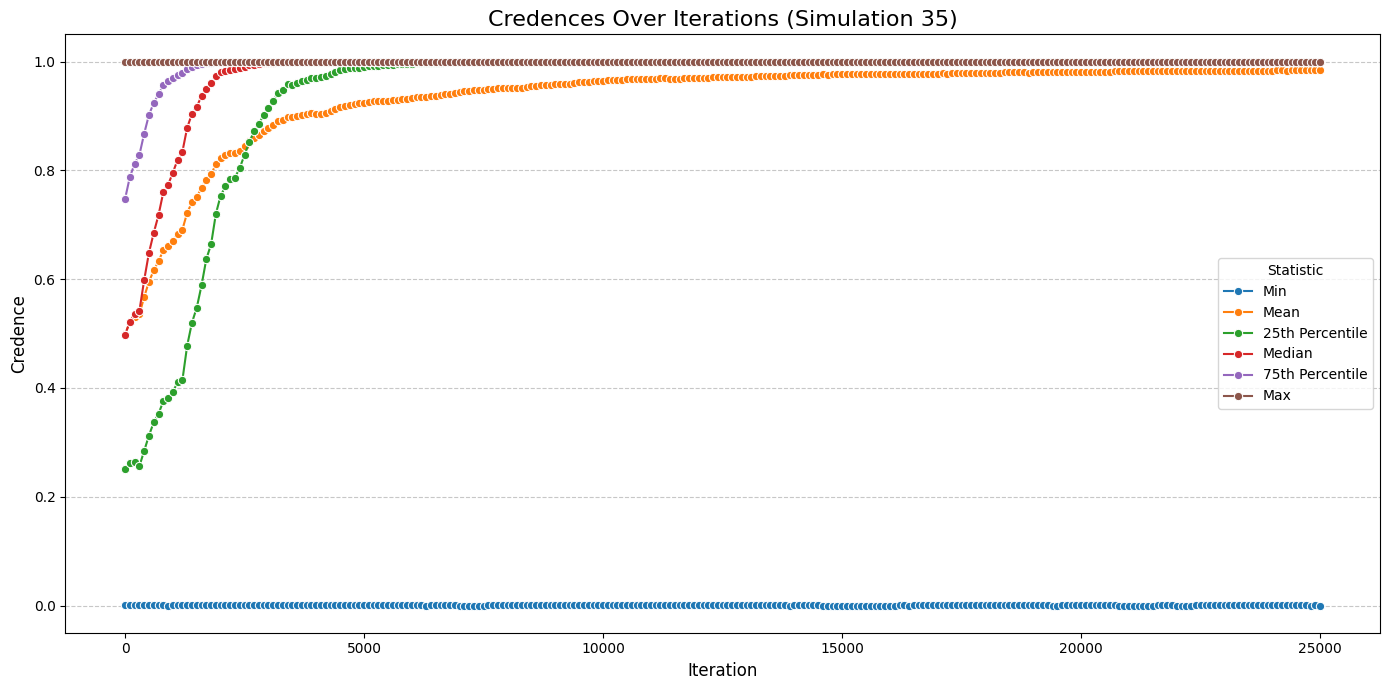

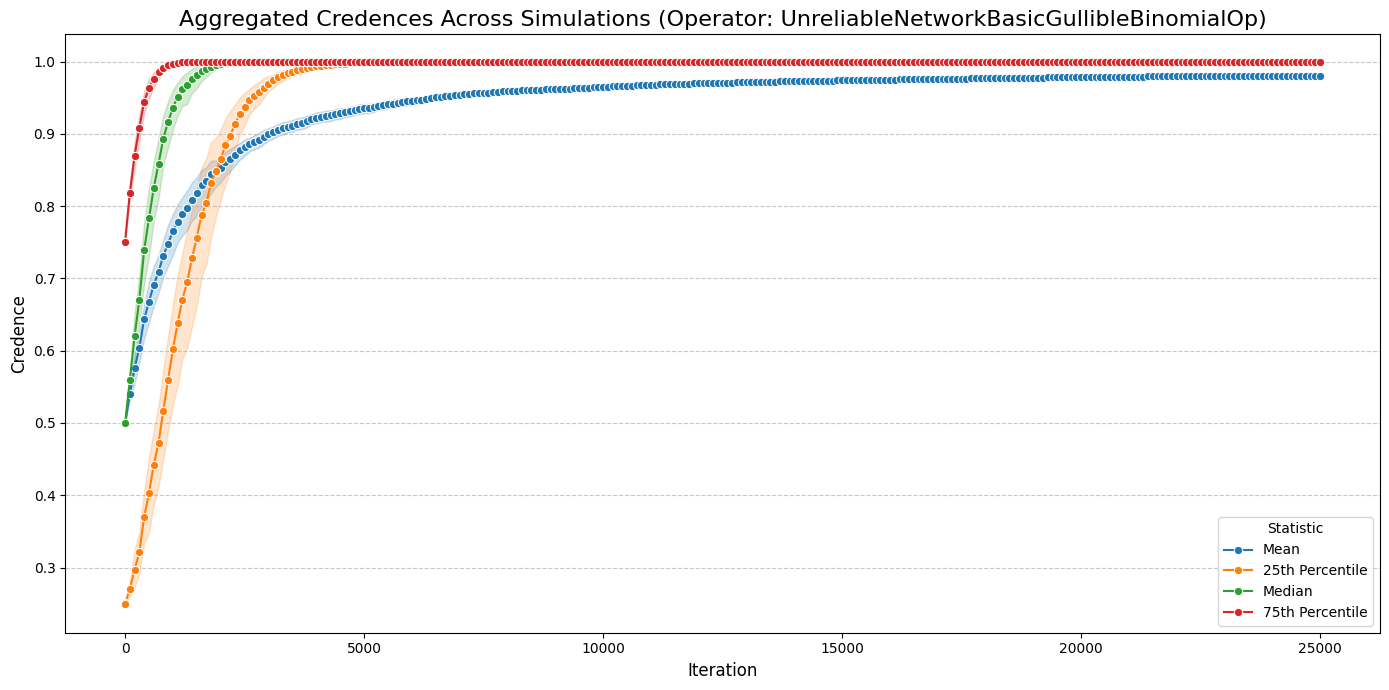

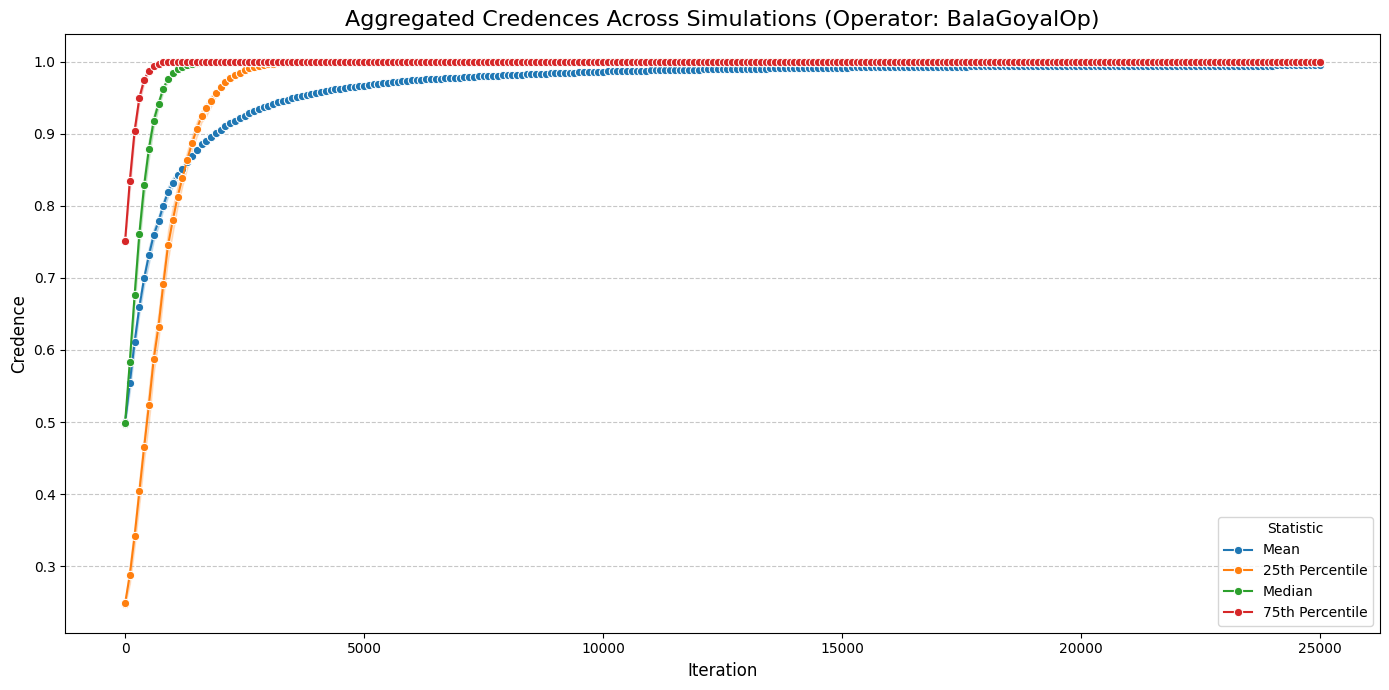

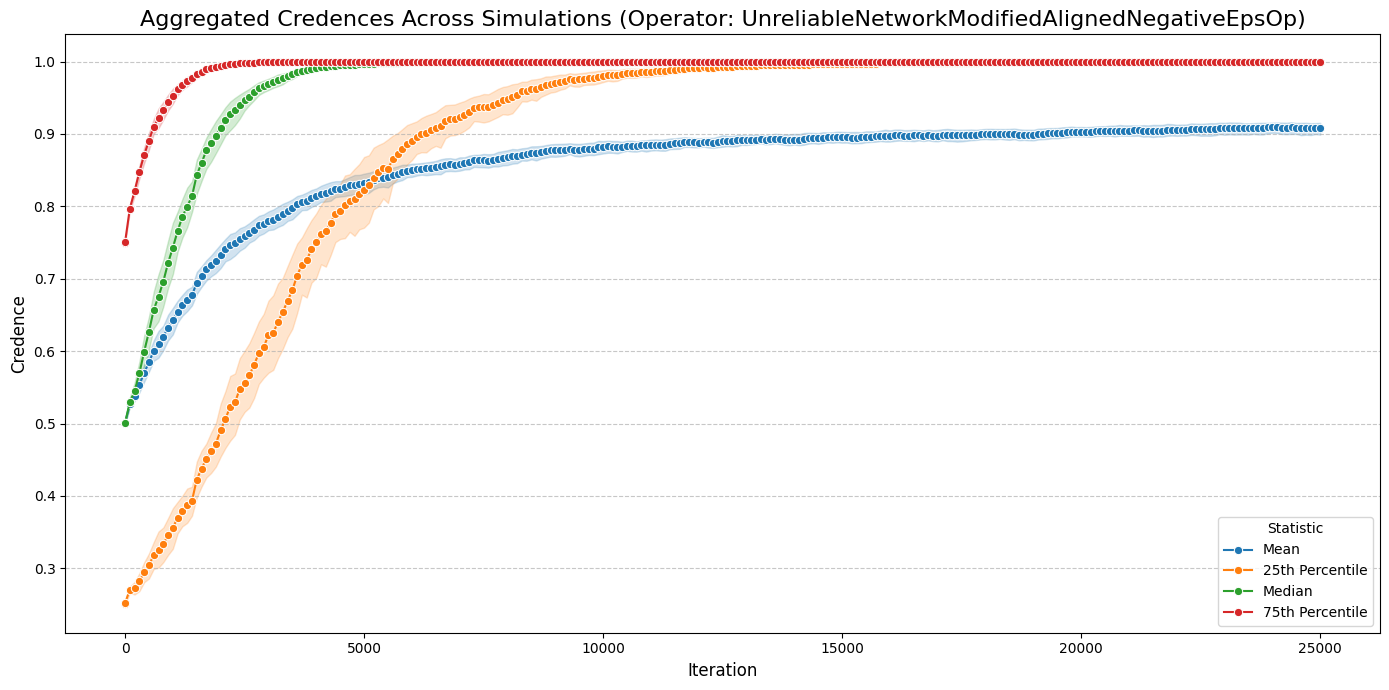

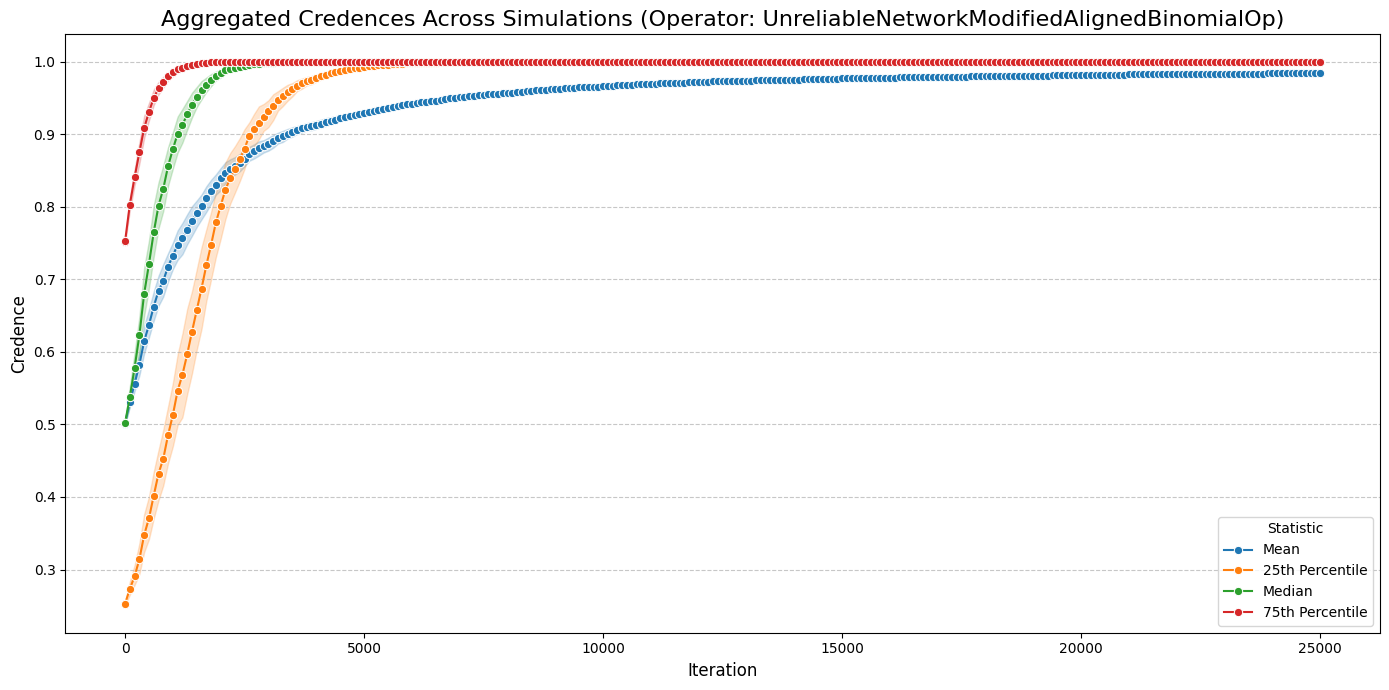

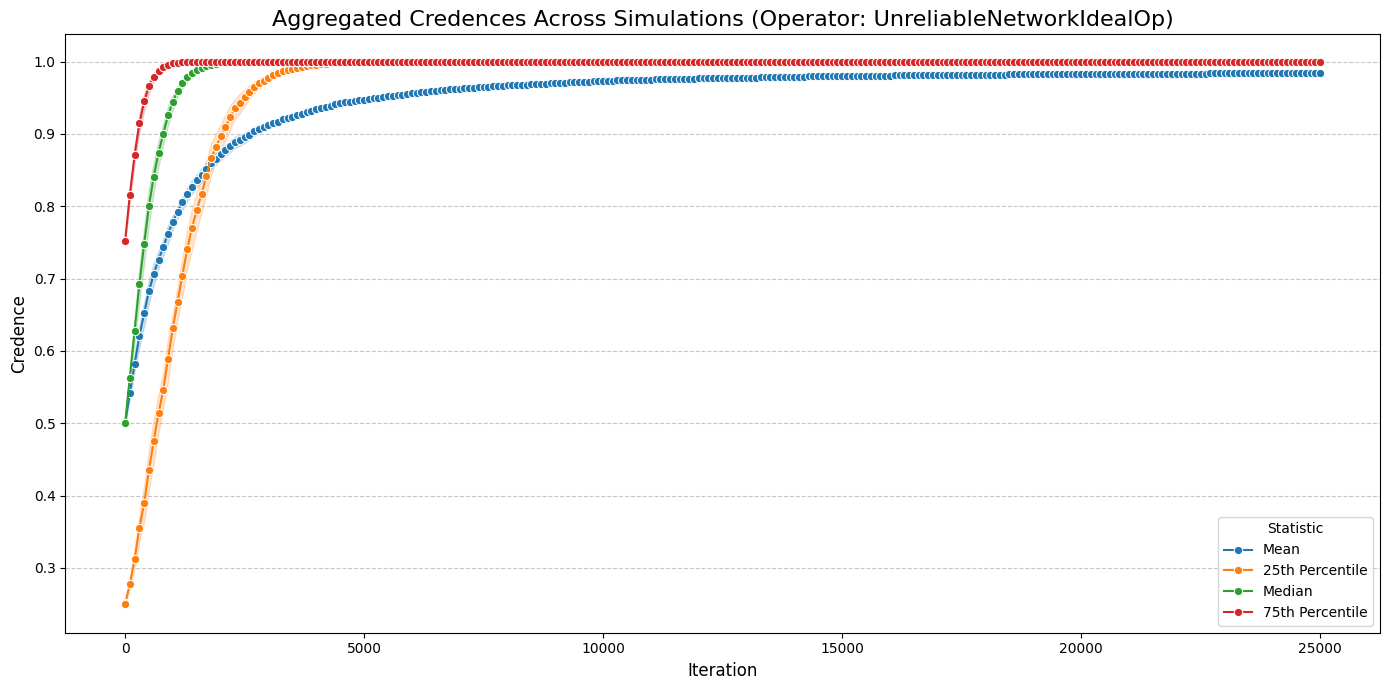

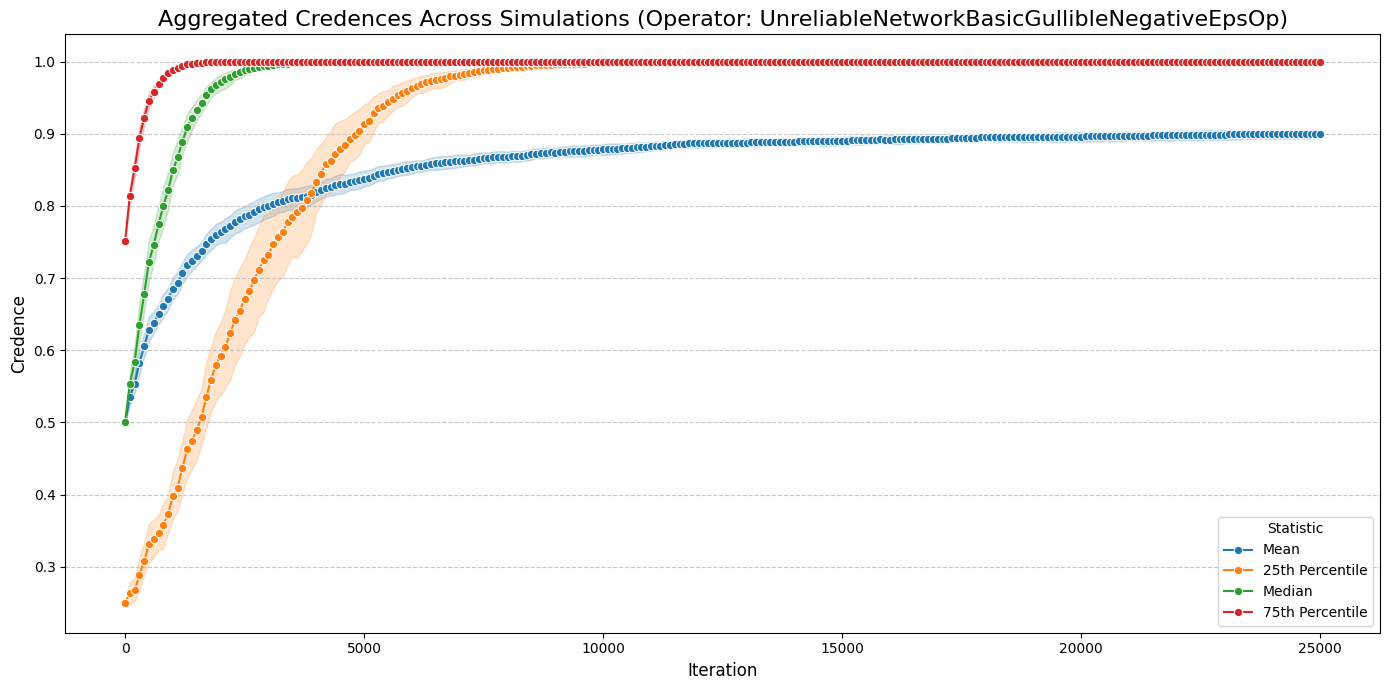

In [16]:
# Single Simulation Visualization
sim_id = 35
single_sim_beliefs = processor.beliefs[sim_id].reset_index()

# Compute statistics by iteration
single_sim_stats = (
    single_sim_beliefs.groupby(["iteration"])
    .agg(
        min_beliefs=("beliefs", "min"),
        mean_beliefs=("beliefs", "mean"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        median_beliefs=("beliefs", "median"),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75)),
        max_beliefs=("beliefs", "max")
    )
    .reset_index()
)

# Plot Single Simulation
plt.figure(figsize=(14, 7))
sns.lineplot(data=single_sim_stats, x="iteration", y="min_beliefs", label="Min", marker="o")
sns.lineplot(data=single_sim_stats, x="iteration", y="mean_beliefs", label="Mean", marker="o")
sns.lineplot(data=single_sim_stats, x="iteration", y="p25_beliefs", label="25th Percentile", marker="o")
sns.lineplot(data=single_sim_stats, x="iteration", y="median_beliefs", label="Median", marker="o")
sns.lineplot(data=single_sim_stats, x="iteration", y="p75_beliefs", label="75th Percentile", marker="o")
sns.lineplot(data=single_sim_stats, x="iteration", y="max_beliefs", label="Max", marker="o")
plt.title(f"Credences Over Iterations (Simulation {sim_id})", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Credence", fontsize=12)
plt.legend(title="Statistic")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Aggregated Visualizations by Operator
single_sim_agg_stats = []
for sim_id, sim_row in processor.sims.iterrows():
    single_sim_beliefs = processor.beliefs[sim_id].reset_index()
    single_sim_beliefs["op"] = sim_row.op

    # Compute statistics by operator and iteration
    stats = (
        single_sim_beliefs.groupby(["op", "iteration"])
        .agg(
            min_beliefs=("beliefs", "min"),
            mean_beliefs=("beliefs", "mean"),
            p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
            median_beliefs=("beliefs", "median"),
            p75_beliefs=("beliefs", lambda x: x.quantile(0.75)),
            max_beliefs=("beliefs", "max")
        )
        .reset_index()
    )
    single_sim_agg_stats.append(stats)

# Combine results across simulations
single_sim_agg_stats_df = pd.concat(single_sim_agg_stats)

# Plot Aggregated Visualizations for Each Operator
for op in single_sim_agg_stats_df["op"].unique():
    op_data = single_sim_agg_stats_df[single_sim_agg_stats_df["op"] == op]

    plt.figure(figsize=(14, 7))
    # sns.lineplot(data=op_data, x="iteration", y="min_beliefs", label="Min", marker="o")
    sns.lineplot(data=op_data, x="iteration", y="mean_beliefs", label="Mean", marker="o")
    sns.lineplot(data=op_data, x="iteration", y="p25_beliefs", label="25th Percentile", marker="o")
    sns.lineplot(data=op_data, x="iteration", y="median_beliefs", label="Median", marker="o")
    sns.lineplot(data=op_data, x="iteration", y="p75_beliefs", label="75th Percentile", marker="o")
    # sns.lineplot(data=op_data, x="iteration", y="max_beliefs", label="Max", marker="o")
    plt.title(f"Aggregated Credences Across Simulations (Operator: {op})", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.legend(title="Statistic")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


In [18]:
# # Across Simulations Visualization

# def visualize_across_sims(beliefs):
#     # Compute statistics by iteration
#     across_sim_stats = (
#         beliefs.groupby(["iteration"])
#         .agg(
#             min_beliefs=("beliefs", "min"),
#             mean_beliefs=("beliefs", "mean"),
#             p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
#             median_beliefs=("beliefs", "median"),
#             p75_beliefs=("beliefs", lambda x: x.quantile(0.75)),
#             max_beliefs=("beliefs", "max")
#         )
#         .reset_index()
#     )

#     # Plot Single Simulation
#     plt.figure(figsize=(14, 7))
#     sns.lineplot(data=across_sim_stats, x="iteration", y="min_beliefs", label="Min", marker="o")
#     sns.lineplot(data=across_sim_stats, x="iteration", y="mean_beliefs", label="Mean", marker="o")
#     sns.lineplot(data=across_sim_stats, x="iteration", y="p25_beliefs", label="25th Percentile", marker="o")
#     sns.lineplot(data=across_sim_stats, x="iteration", y="median_beliefs", label="Median", marker="o")
#     sns.lineplot(data=across_sim_stats, x="iteration", y="p75_beliefs", label="75th Percentile", marker="o")
#     sns.lineplot(data=across_sim_stats, x="iteration", y="max_beliefs", label="Max", marker="o")
#     plt.title(f"Credences Over Iterations", fontsize=16)
#     plt.xlabel("Iteration", fontsize=12)
#     plt.ylabel("Credence", fontsize=12)
#     plt.legend(title="Statistic")
#     plt.grid(axis="y", linestyle="--", alpha=0.7)
#     plt.tight_layout()
#     plt.show()


# def visualize_across_sims_by_op(beliefs, title=''):
#     # Compute statistics by operator and iteration
#     agg_stats_df = (
#         beliefs.groupby(["op", "iteration"])
#         .agg(
#             min_beliefs=("beliefs", "min"),
#             p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
#             mean_beliefs=("beliefs", "mean"),
#             median_beliefs=("beliefs", "median"),
#             p75_beliefs=("beliefs", lambda x: x.quantile(0.75)),
#             max_beliefs=("beliefs", "max")
#         )
#         .reset_index()
#     )

#     # Plot Aggregated Visualizations for Each Operator
#     for op in agg_stats_df["op"].unique():
#         op_data = agg_stats_df[agg_stats_df["op"] == op]

#         plt.figure(figsize=(14, 7))
#         # sns.lineplot(data=op_data, x="iteration", y="min_beliefs", label="Min", marker="o")
#         sns.lineplot(data=op_data, x="iteration", y="mean_beliefs", label="Mean", marker="o")
#         sns.lineplot(data=op_data, x="iteration", y="p25_beliefs", label="25th Percentile", marker="o")
#         sns.lineplot(data=op_data, x="iteration", y="median_beliefs", label="Median", marker="o")
#         sns.lineplot(data=op_data, x="iteration", y="p75_beliefs", label="75th Percentile", marker="o")
#         # sns.lineplot(data=op_data, x="iteration", y="max_beliefs", label="Max", marker="o")
#         if title:
#             plt.title(f"{title} (Operator: {op})", fontsize=16)
#         else:
#             plt.title(f"Aggregated Credences Across Simulations (Operator: {op})", fontsize=16)
#         plt.xlabel("Iteration", fontsize=12)
#         plt.ylabel("Credence", fontsize=12)
#         plt.legend(title="Statistic")
#         plt.grid(axis="y", linestyle="--", alpha=0.7)
#         plt.tight_layout()
#         plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_across_sims(beliefs):
    """
    Visualizes credences across iterations with overall graph-wide mean.
    """
    # Compute statistics by iteration
    across_sim_stats = (
        beliefs.groupby(["iteration"])
        .agg(
            min_beliefs=("beliefs", "min"),
            mean_beliefs=("beliefs", "mean"),
            p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
            median_beliefs=("beliefs", "median"),
            p75_beliefs=("beliefs", lambda x: x.quantile(0.75)),
            max_beliefs=("beliefs", "max")
        )
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=across_sim_stats, x="iteration", y="min_beliefs", label="Min", marker="o")
    sns.lineplot(data=across_sim_stats, x="iteration", y="mean_beliefs", label="Mean (All Nodes)", marker="o", color='black', linewidth=2)
    sns.lineplot(data=across_sim_stats, x="iteration", y="p25_beliefs", label="25th Percentile", marker="o")
    sns.lineplot(data=across_sim_stats, x="iteration", y="median_beliefs", label="Median", marker="o")
    sns.lineplot(data=across_sim_stats, x="iteration", y="p75_beliefs", label="75th Percentile", marker="o")
    sns.lineplot(data=across_sim_stats, x="iteration", y="max_beliefs", label="Max", marker="o")

    plt.title("Credences Over Iterations", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.legend(title="Statistic")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def visualize_across_sims_by_op(beliefs, title=''):
    """
    Visualizes credences across iterations for each operator, 
    including the mean across all nodes.
    """
    # Compute statistics by operator and iteration
    agg_stats_df = (
        beliefs.groupby(["op", "iteration"])
        .agg(
            min_beliefs=("beliefs", "min"),
            p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
            mean_beliefs=("beliefs", "mean"),
            median_beliefs=("beliefs", "median"),
            p75_beliefs=("beliefs", lambda x: x.quantile(0.75)),
            max_beliefs=("beliefs", "max")
        )
        .reset_index()
    )

    # Compute overall mean across all nodes per iteration (ignoring operators)
    overall_mean_df = (
        beliefs.groupby("iteration")["beliefs"].mean().reset_index()
    )

    # Plot for each operator
    for op in agg_stats_df["op"].unique():
        op_data = agg_stats_df[agg_stats_df["op"] == op]

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=op_data, x="iteration", y="mean_beliefs", label="Mean (Community)", marker="o")
        sns.lineplot(data=op_data, x="iteration", y="p25_beliefs", label="25th Percentile", marker="o")
        sns.lineplot(data=op_data, x="iteration", y="median_beliefs", label="Median", marker="o")
        sns.lineplot(data=op_data, x="iteration", y="p75_beliefs", label="75th Percentile", marker="o")

        # Overlay overall mean across all nodes
        sns.lineplot(data=overall_mean_df, x="iteration", y="beliefs", label="Mean (All Nodes)", color='black', linewidth=2, linestyle="--")

        if title:
            plt.title(f"{title} (Operator: {op})", fontsize=16)
        else:
            plt.title(f"Aggregated Credences Across Simulations (Operator: {op})", fontsize=16)

        plt.xlabel("Iteration", fontsize=12)
        plt.ylabel("Credence", fontsize=12)
        plt.legend(title="Statistic")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()


## Visualize across sims

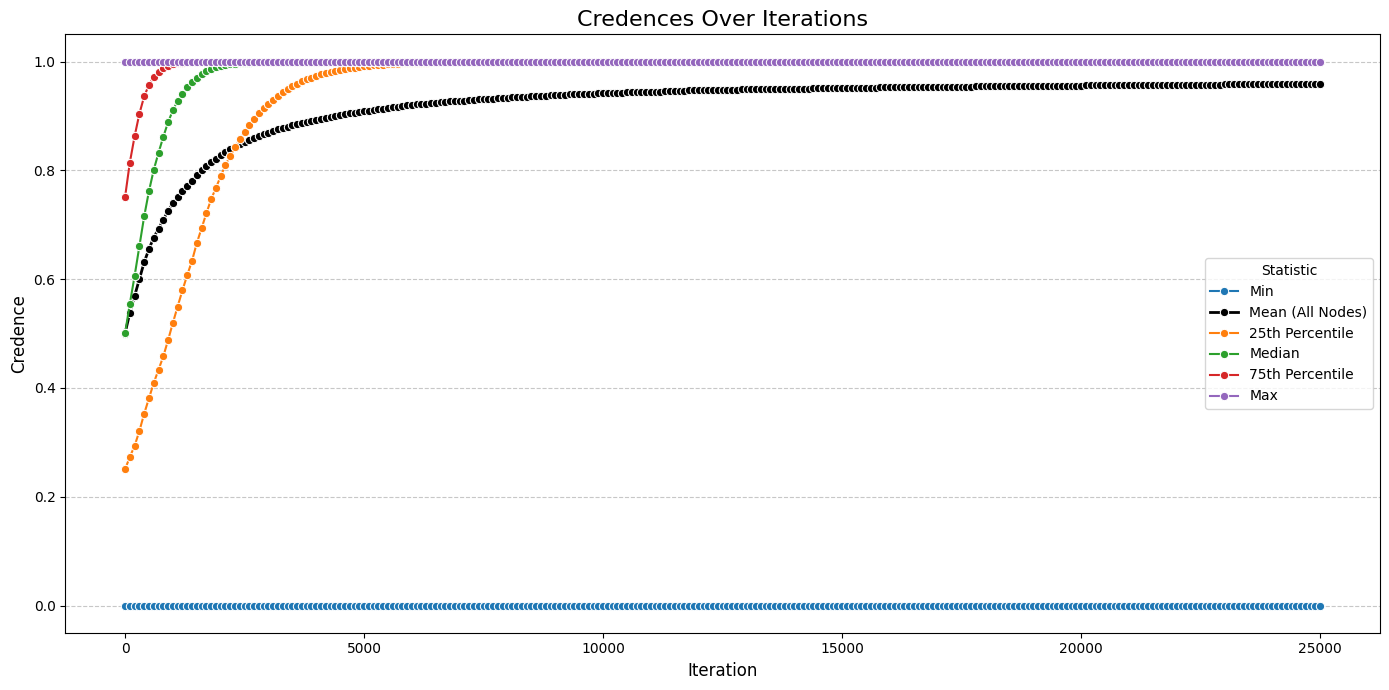

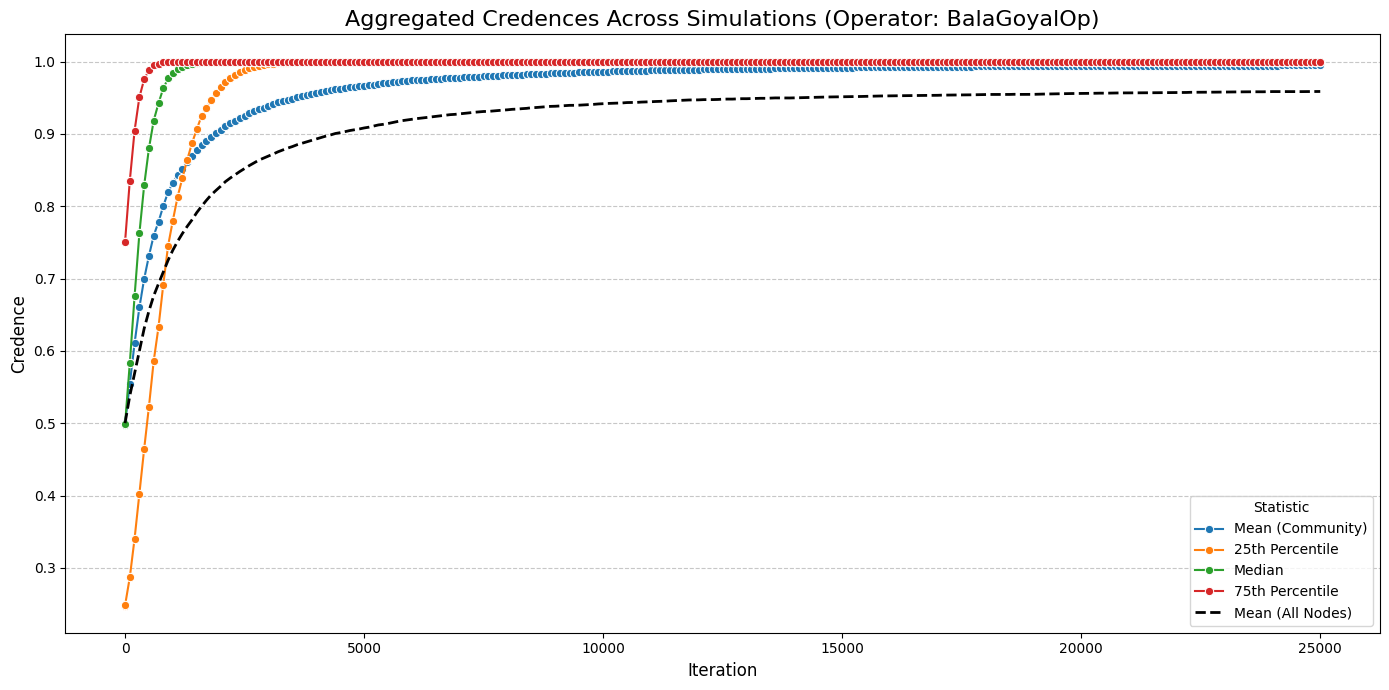

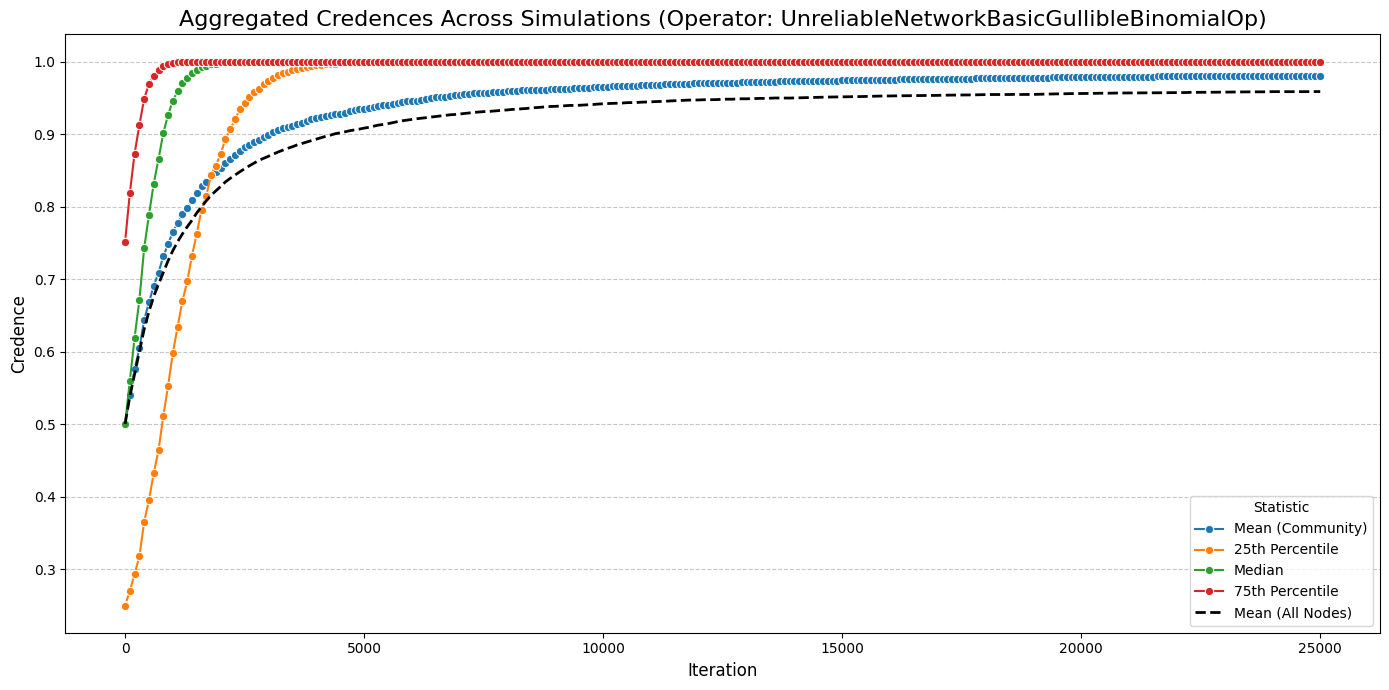

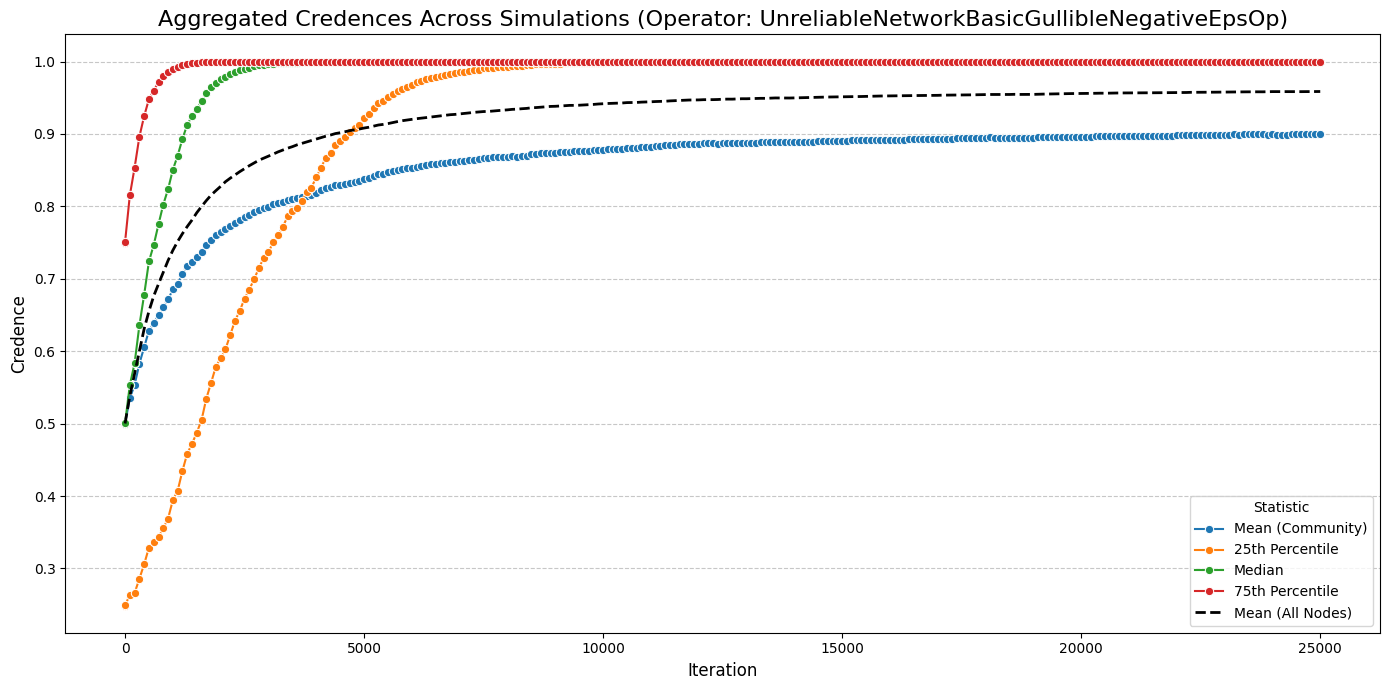

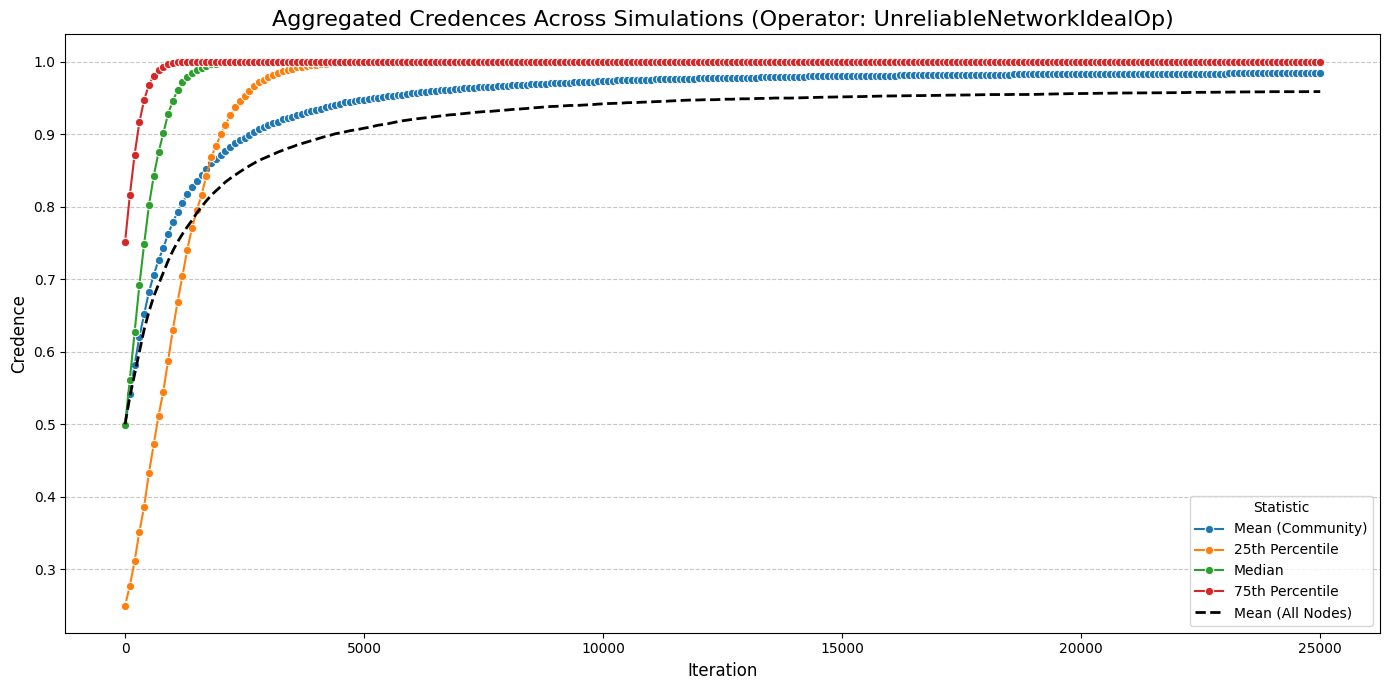

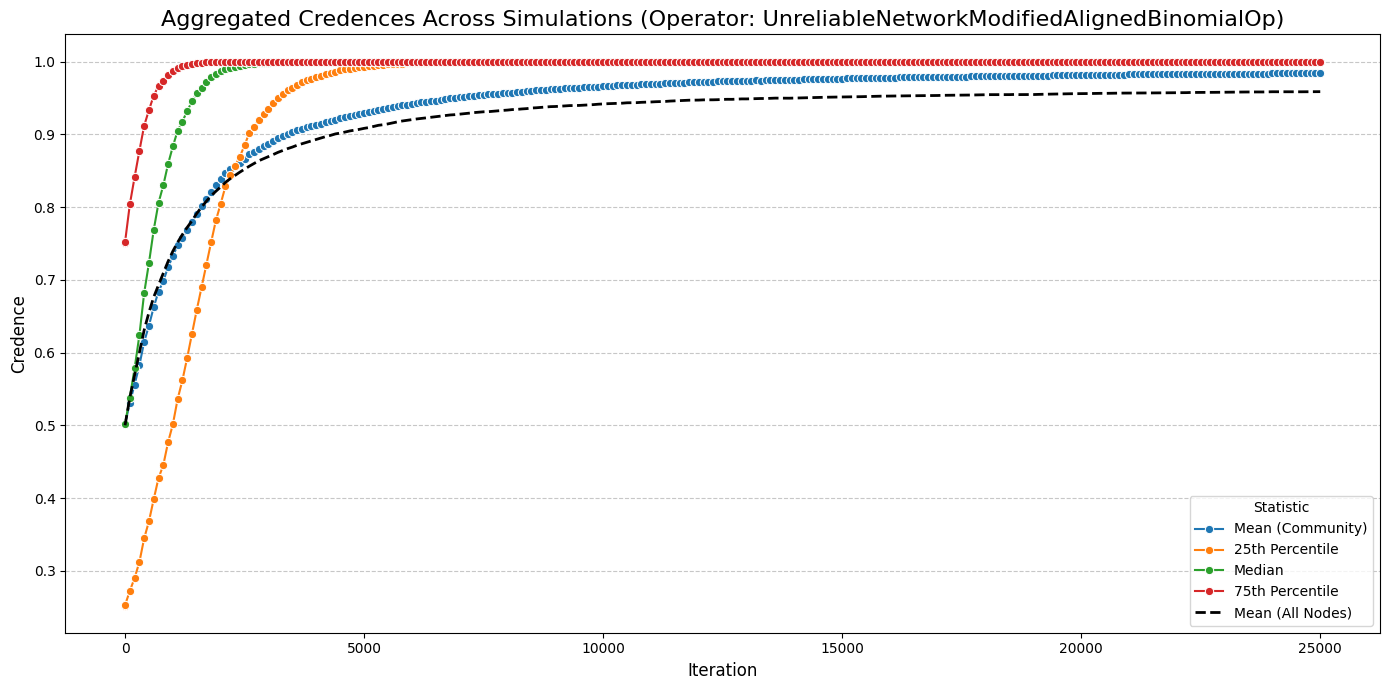

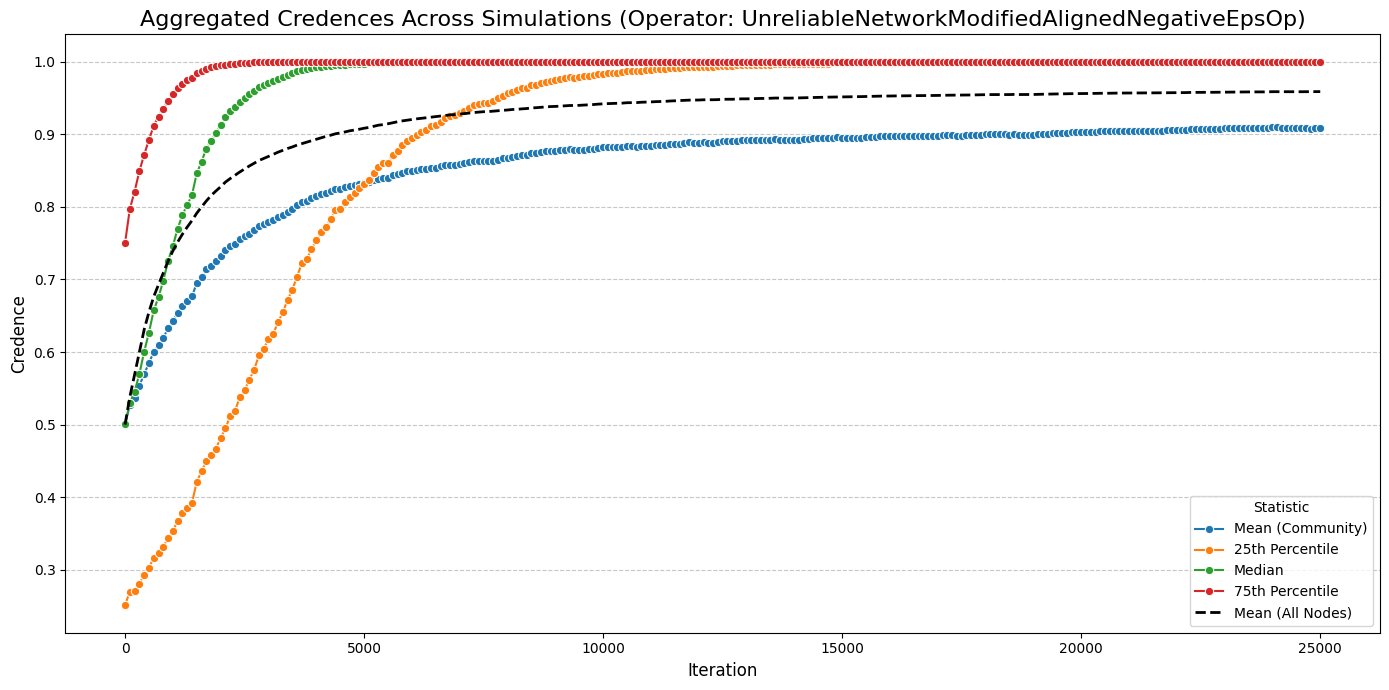

CPU times: user 40.6 s, sys: 35.9 s, total: 1min 16s
Wall time: 3min 21s


In [19]:
%%time

visualize_across_sims(beliefs)
visualize_across_sims_by_op(beliefs)

## Visualize across sims for interested label propagation communities

For the community id 0


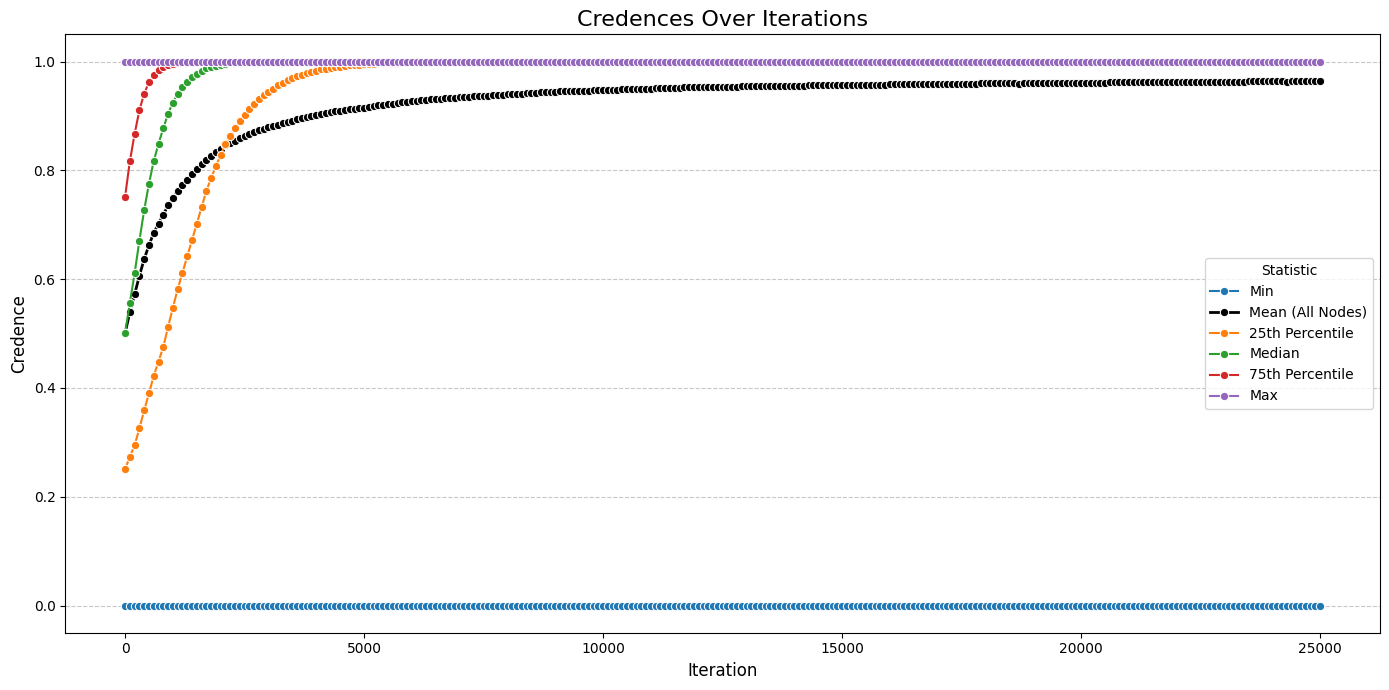

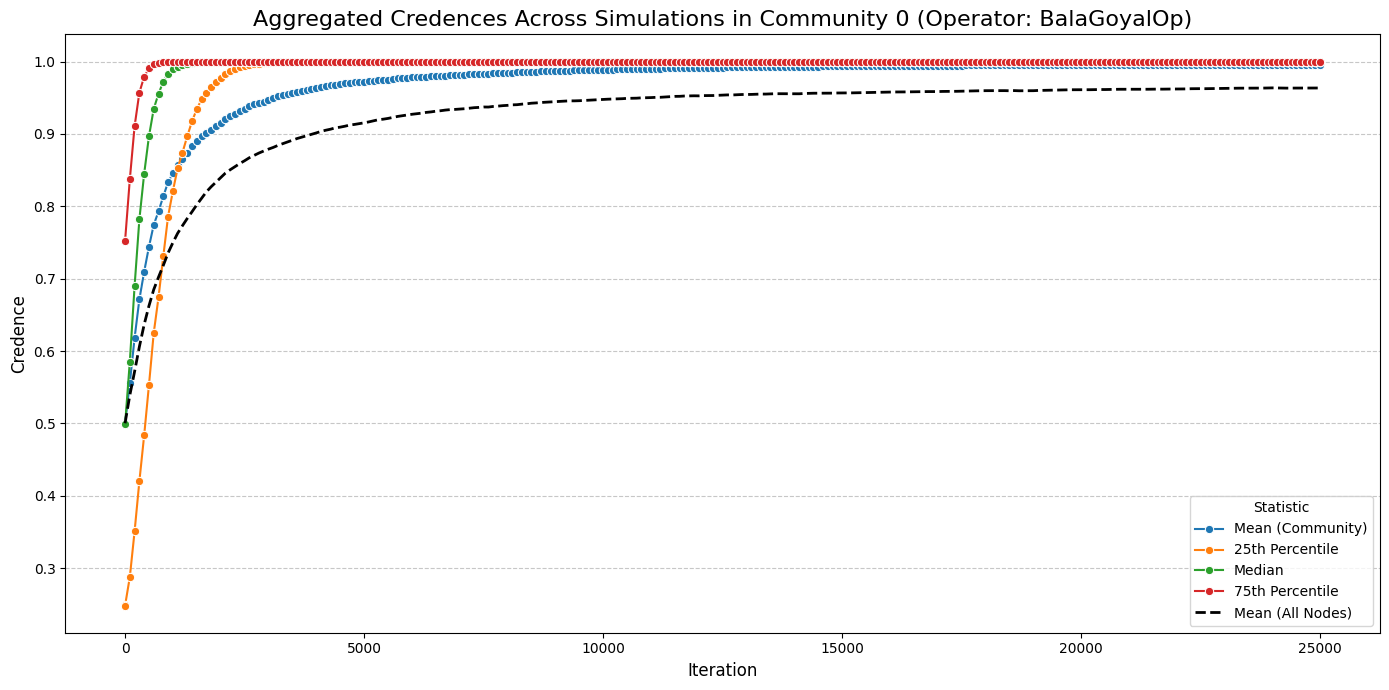

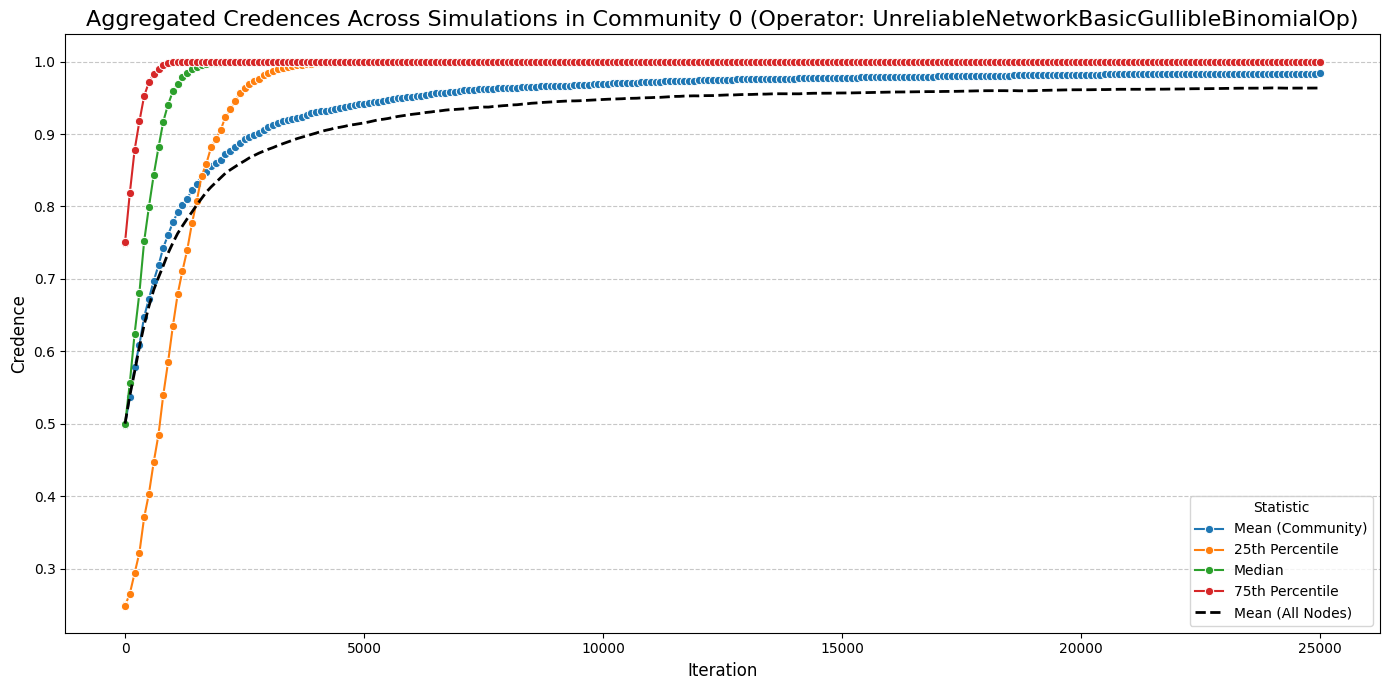

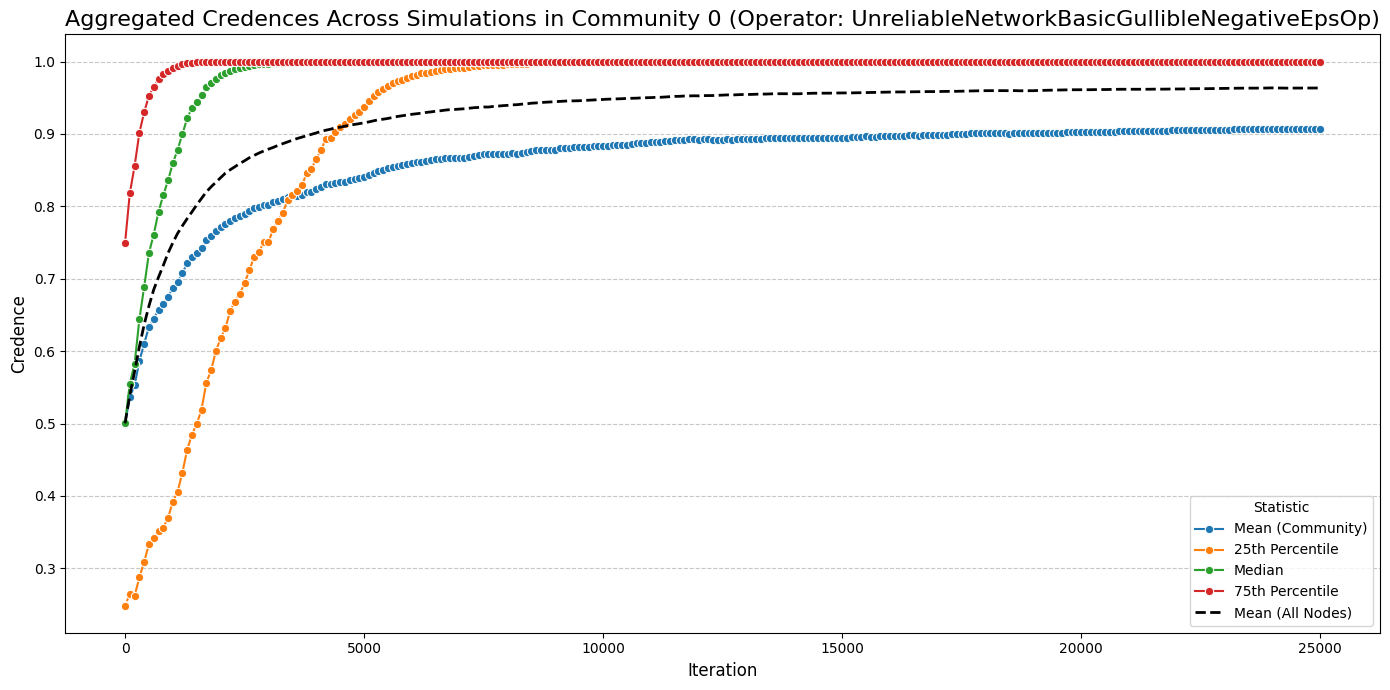

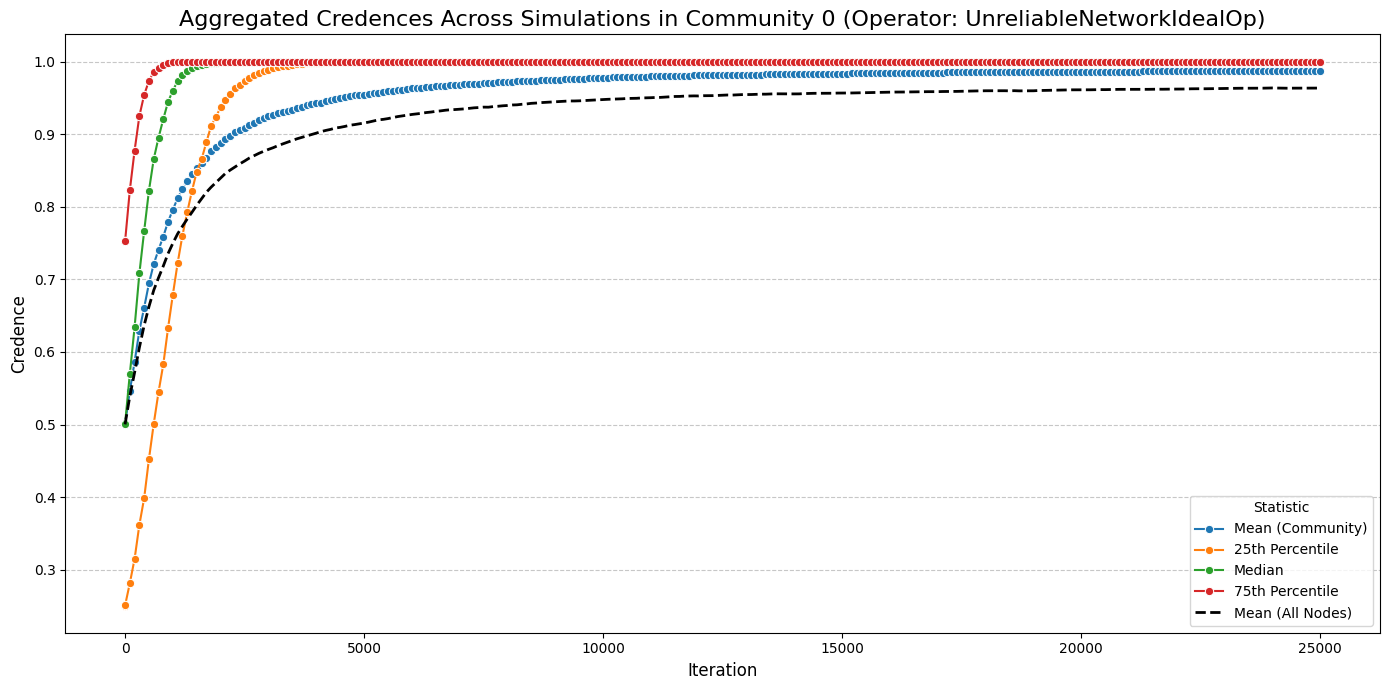

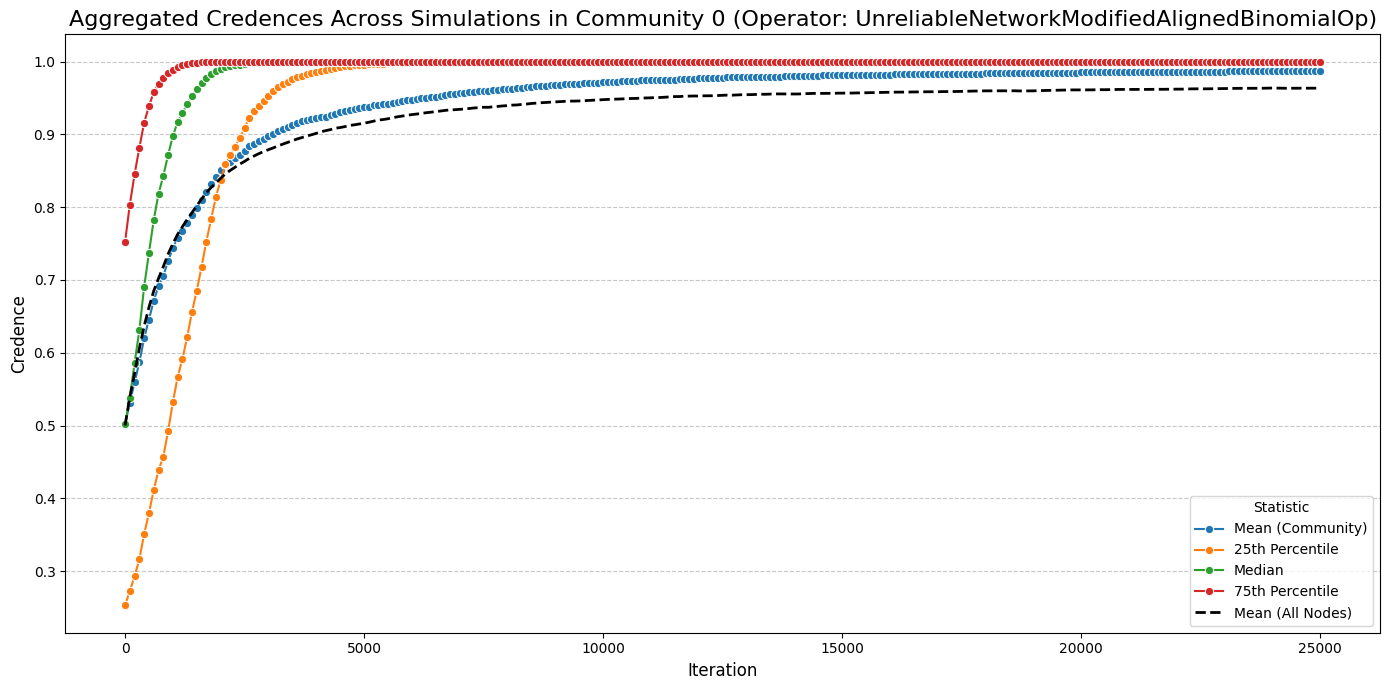

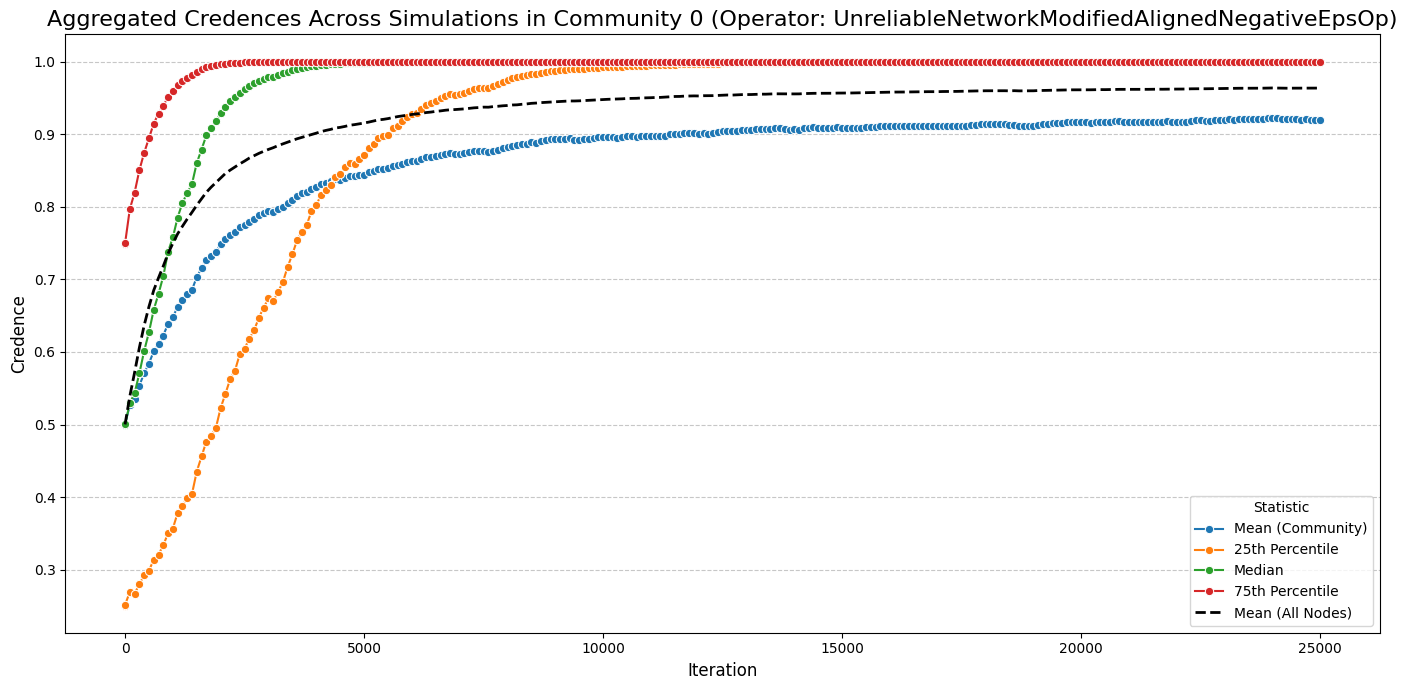

For the community id 3


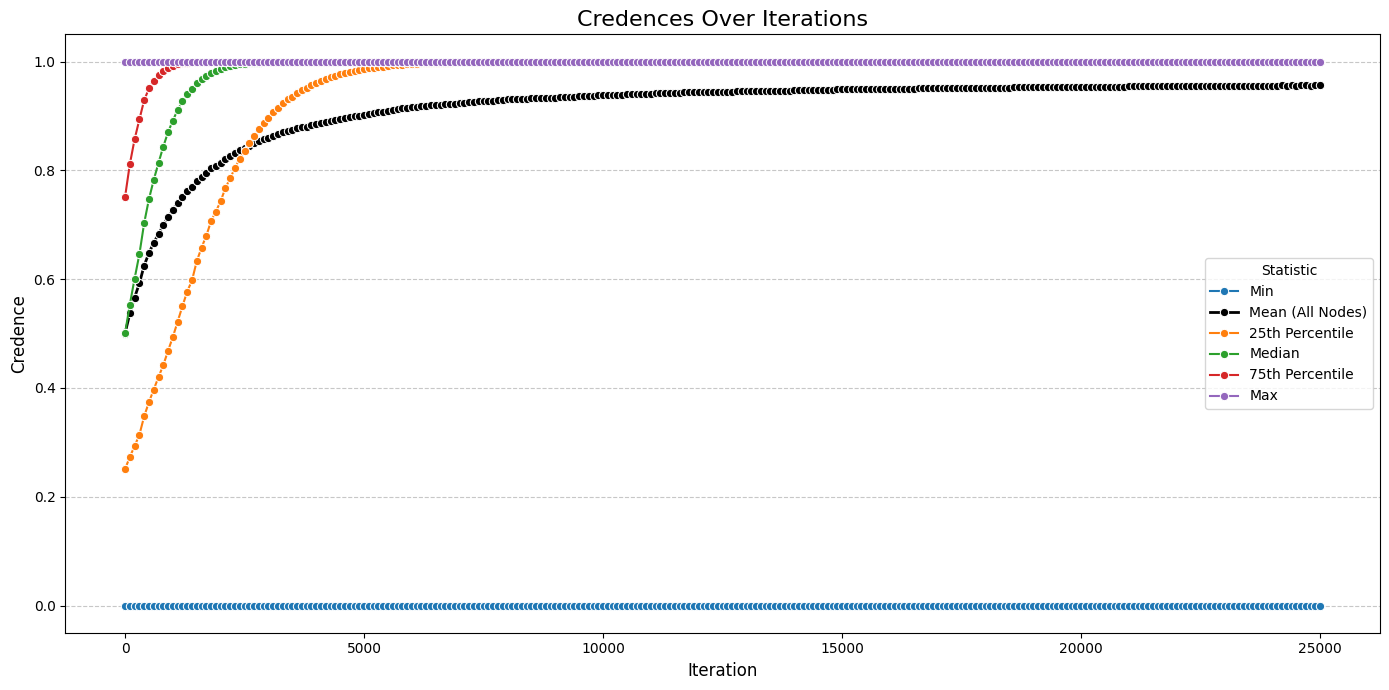

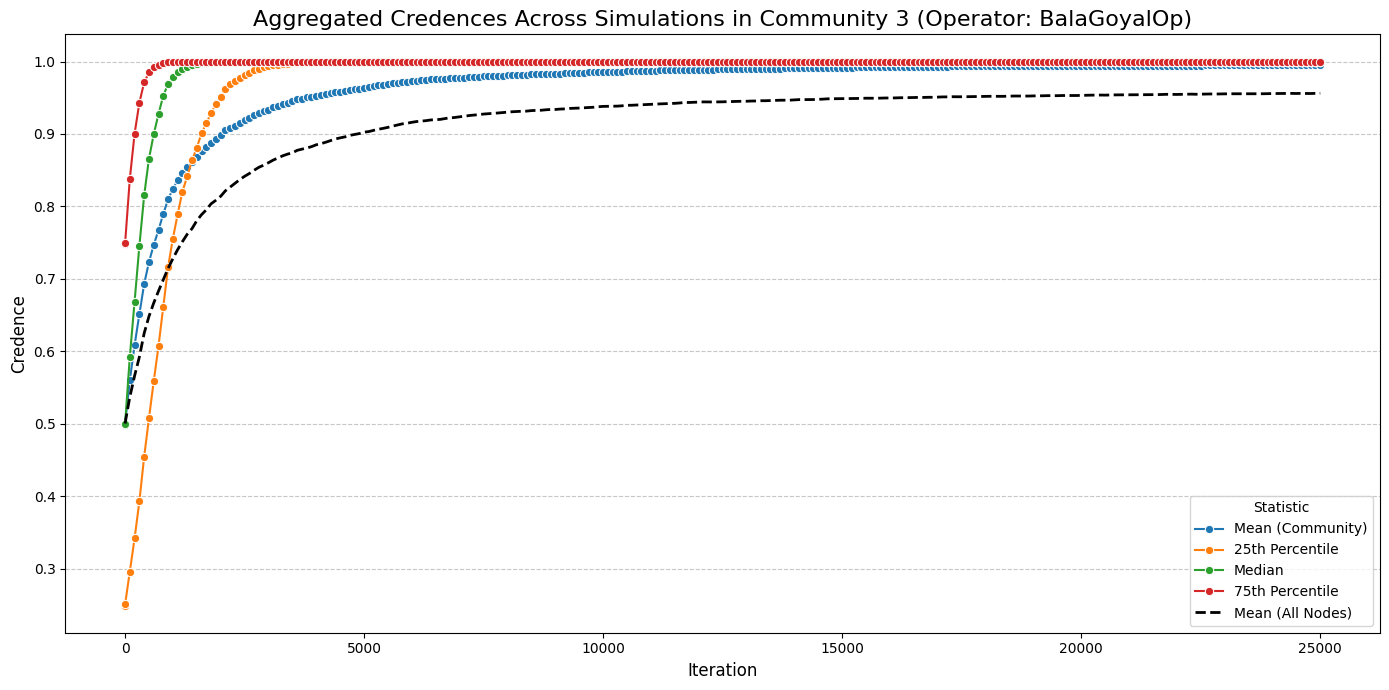

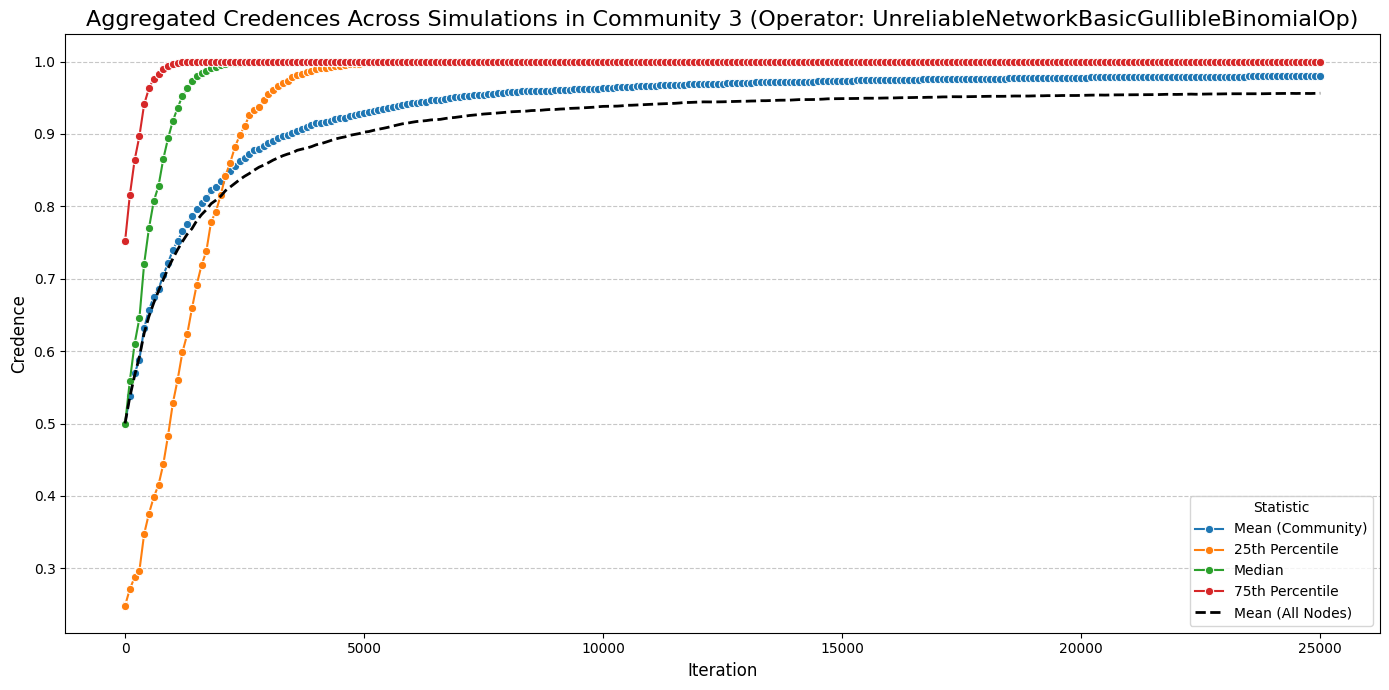

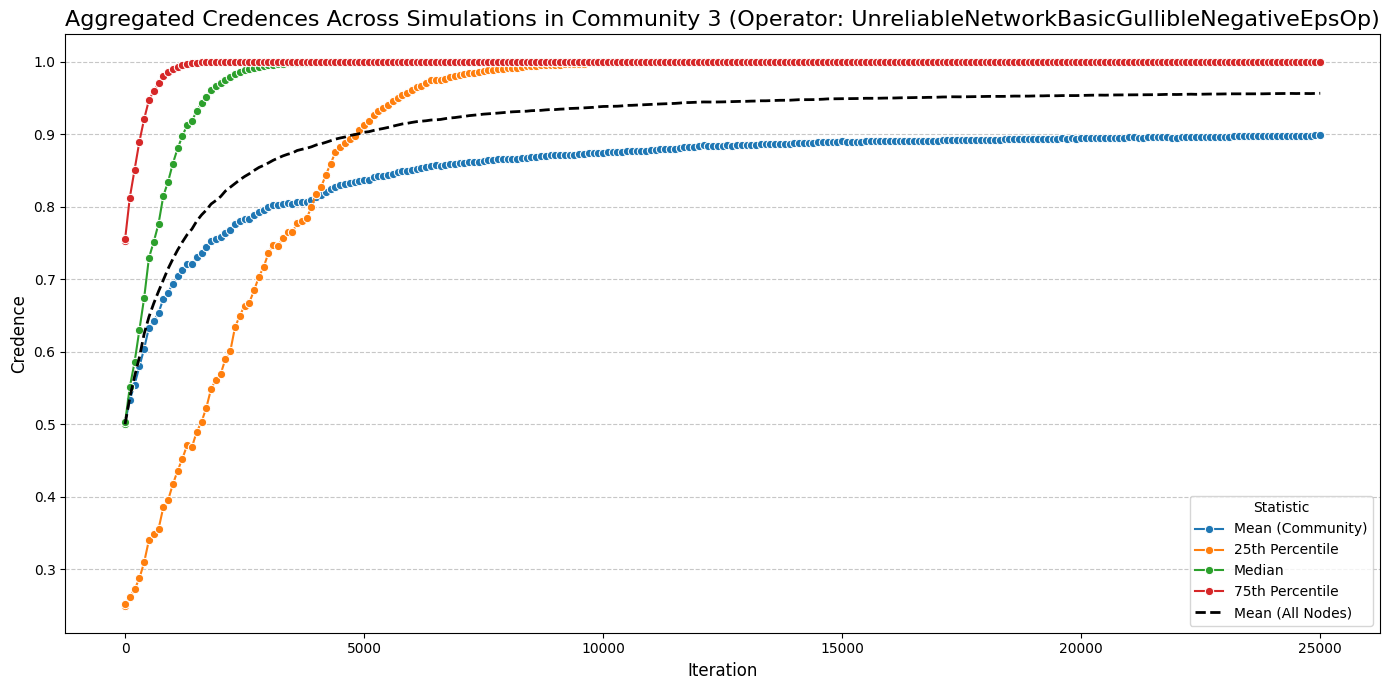

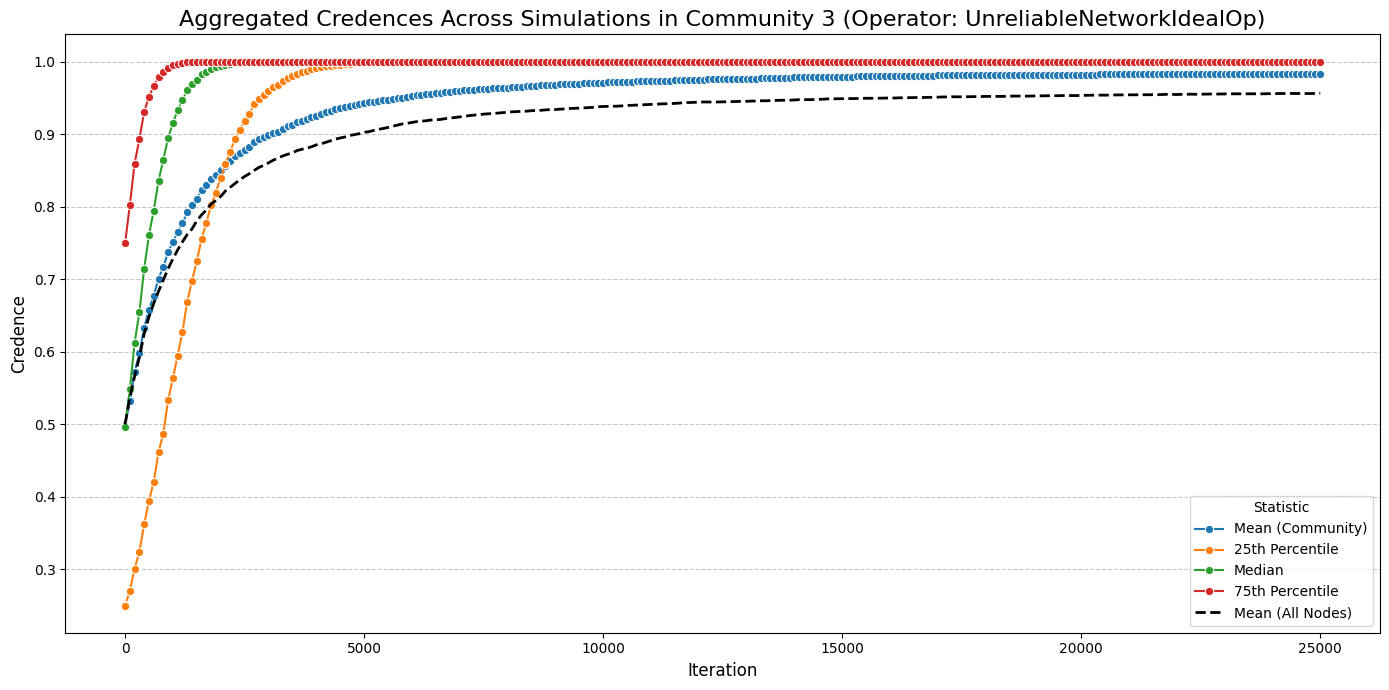

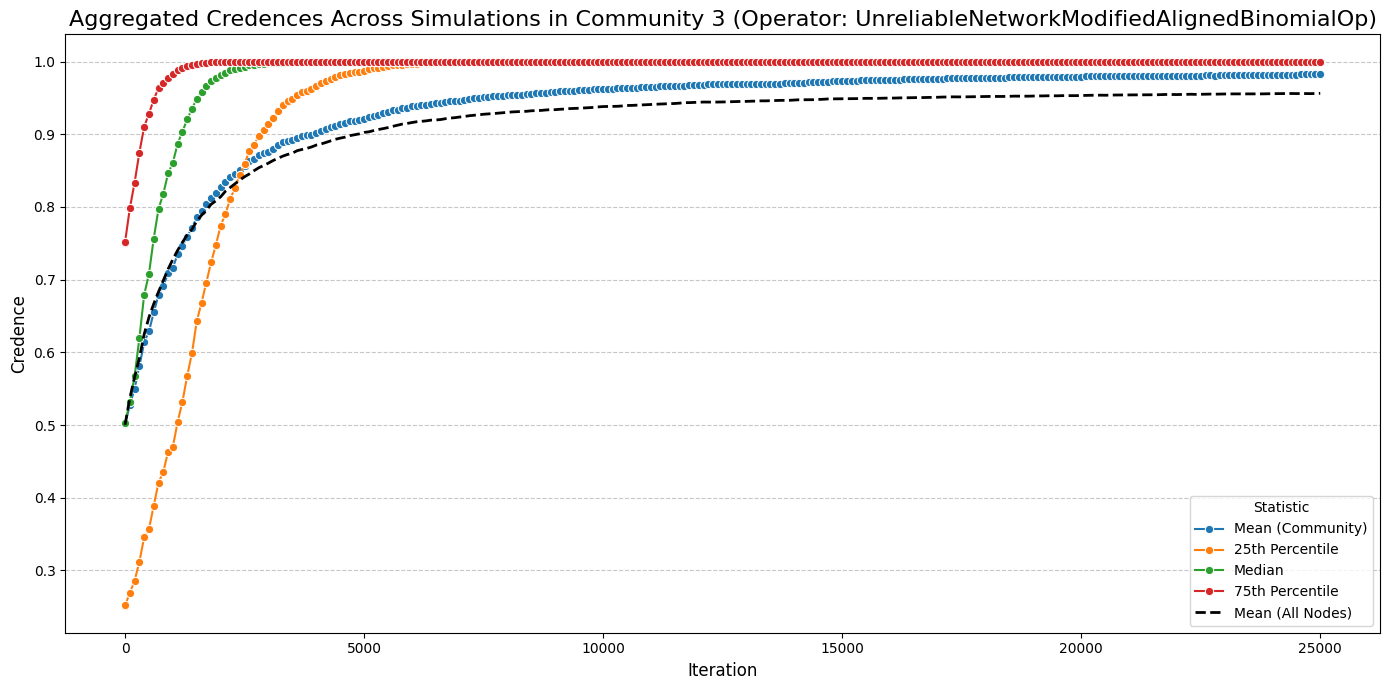

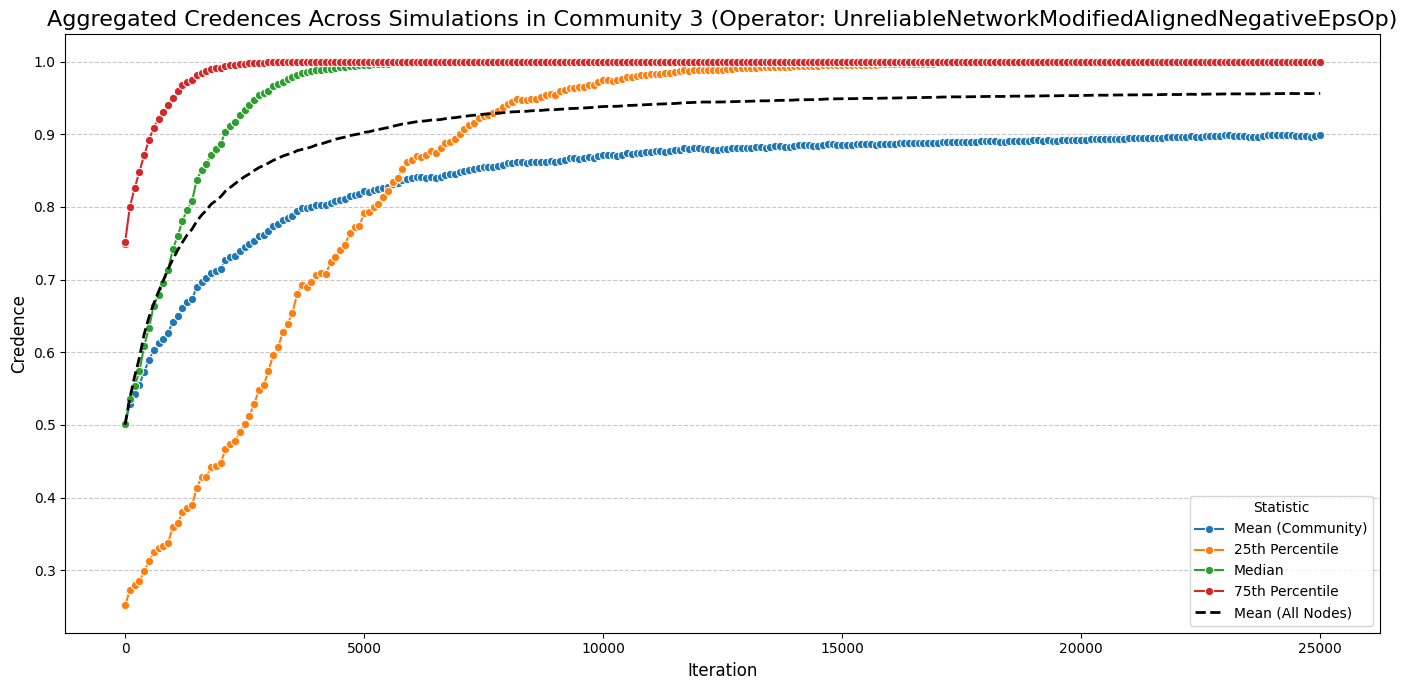

For the community id 1


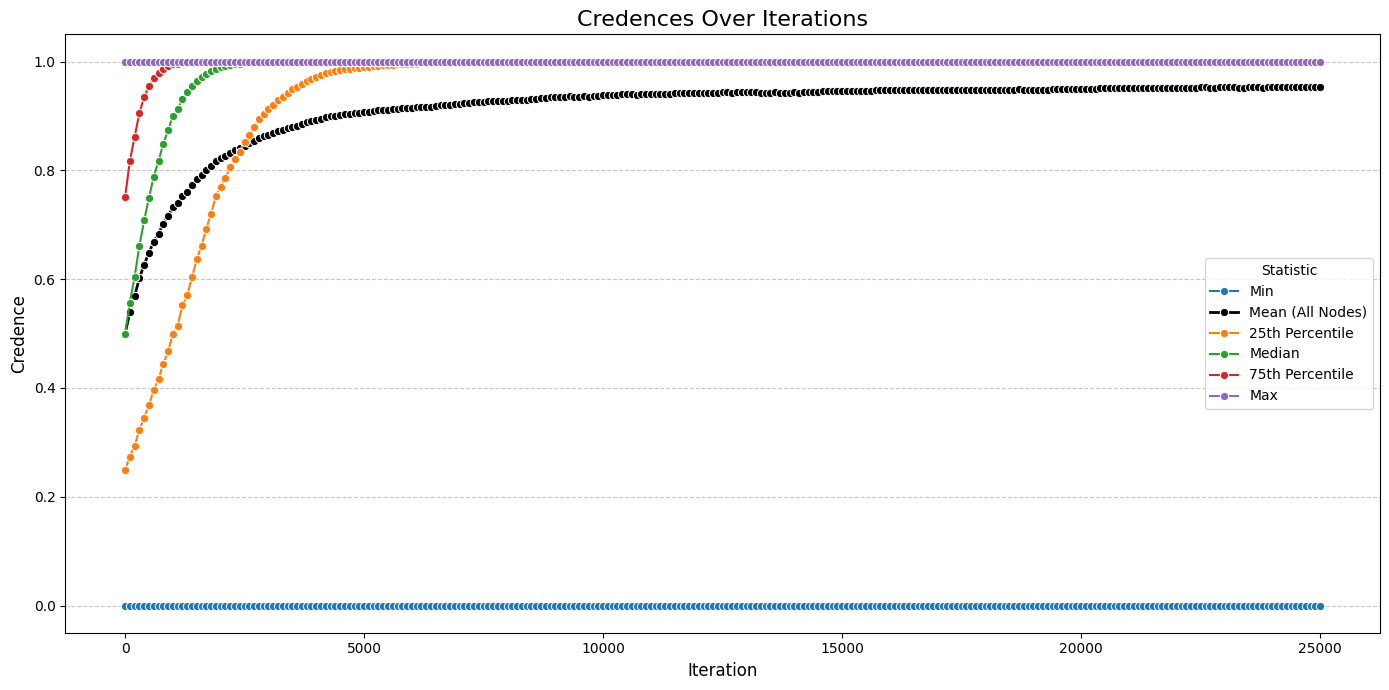

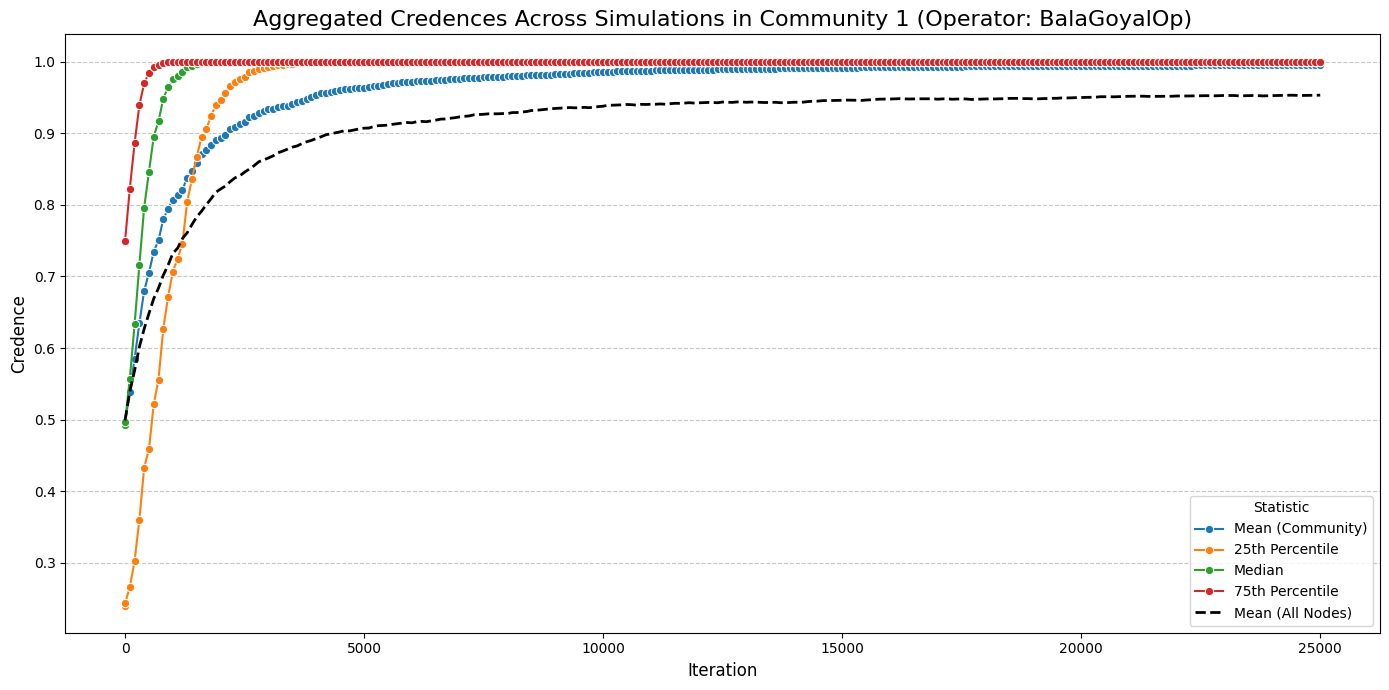

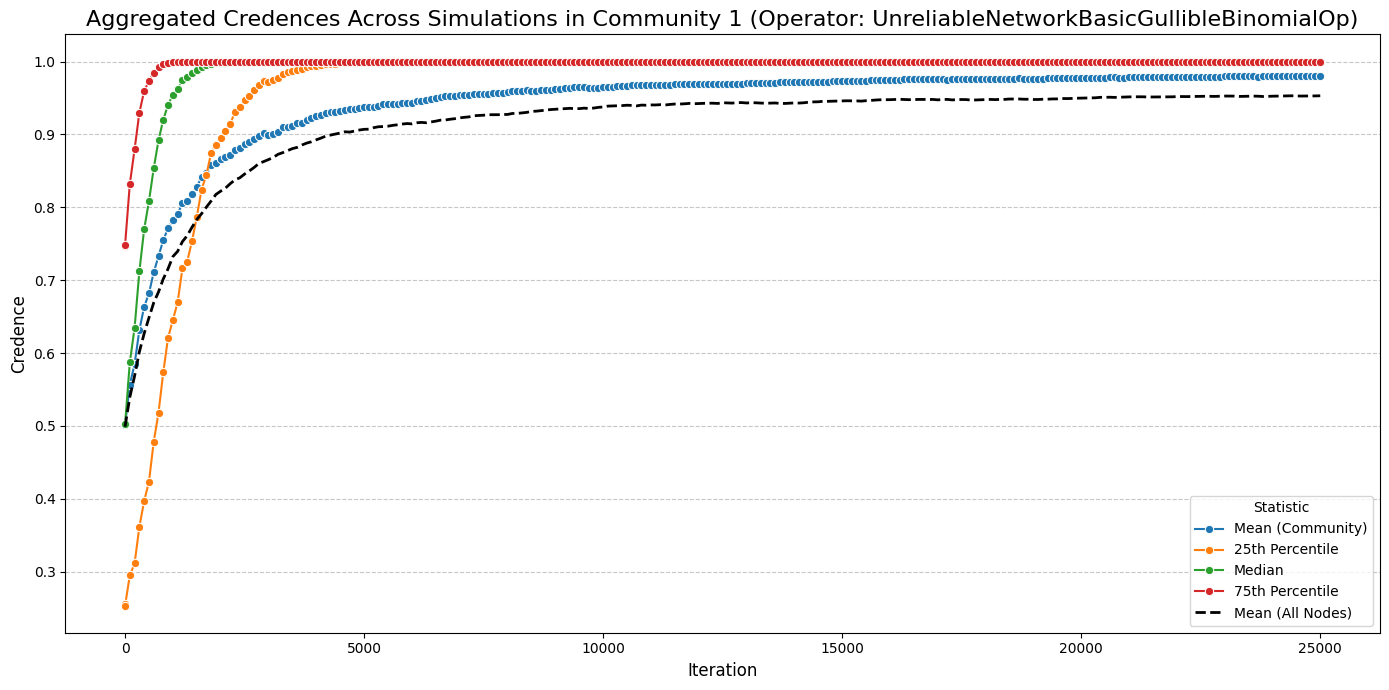

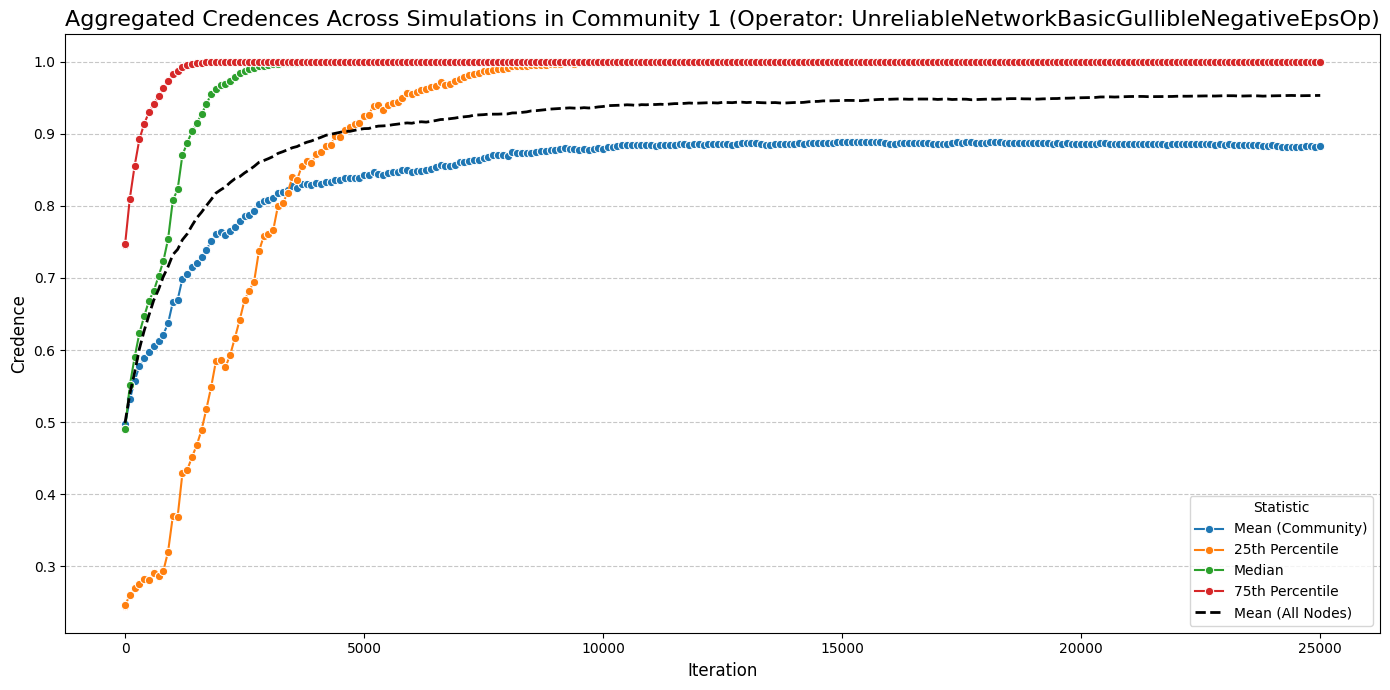

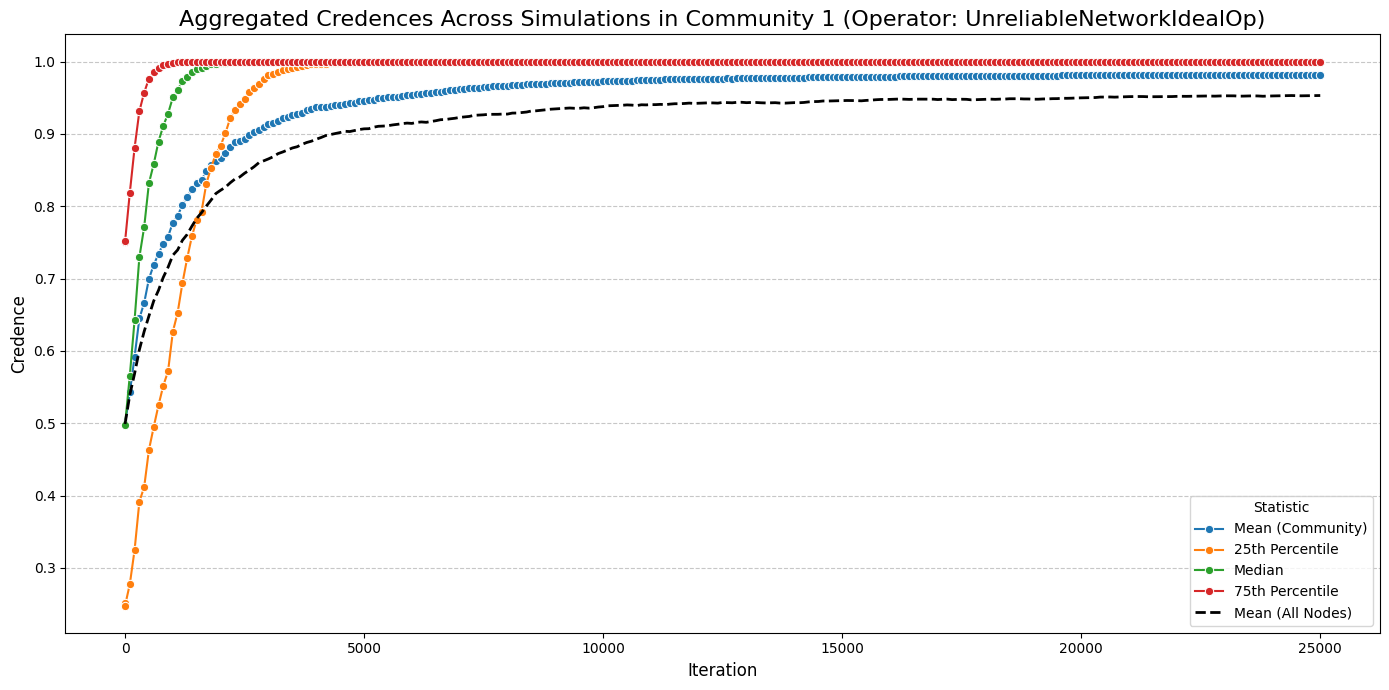

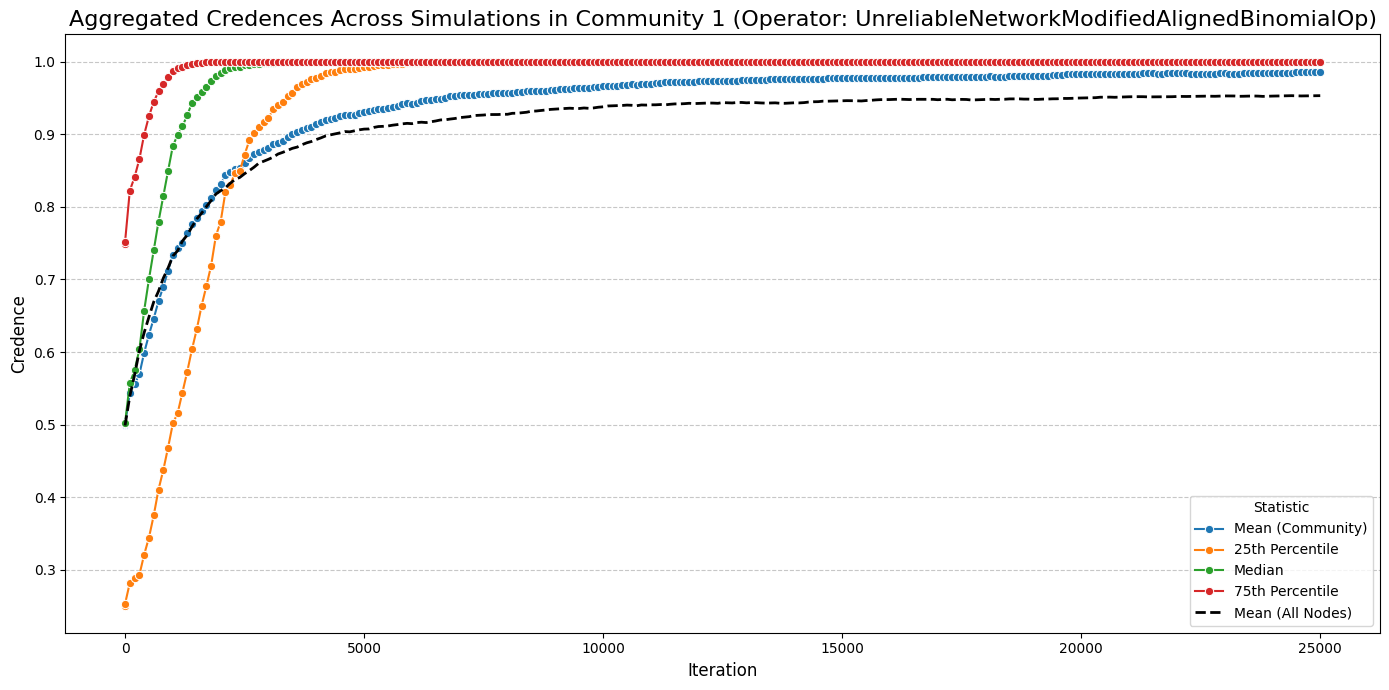

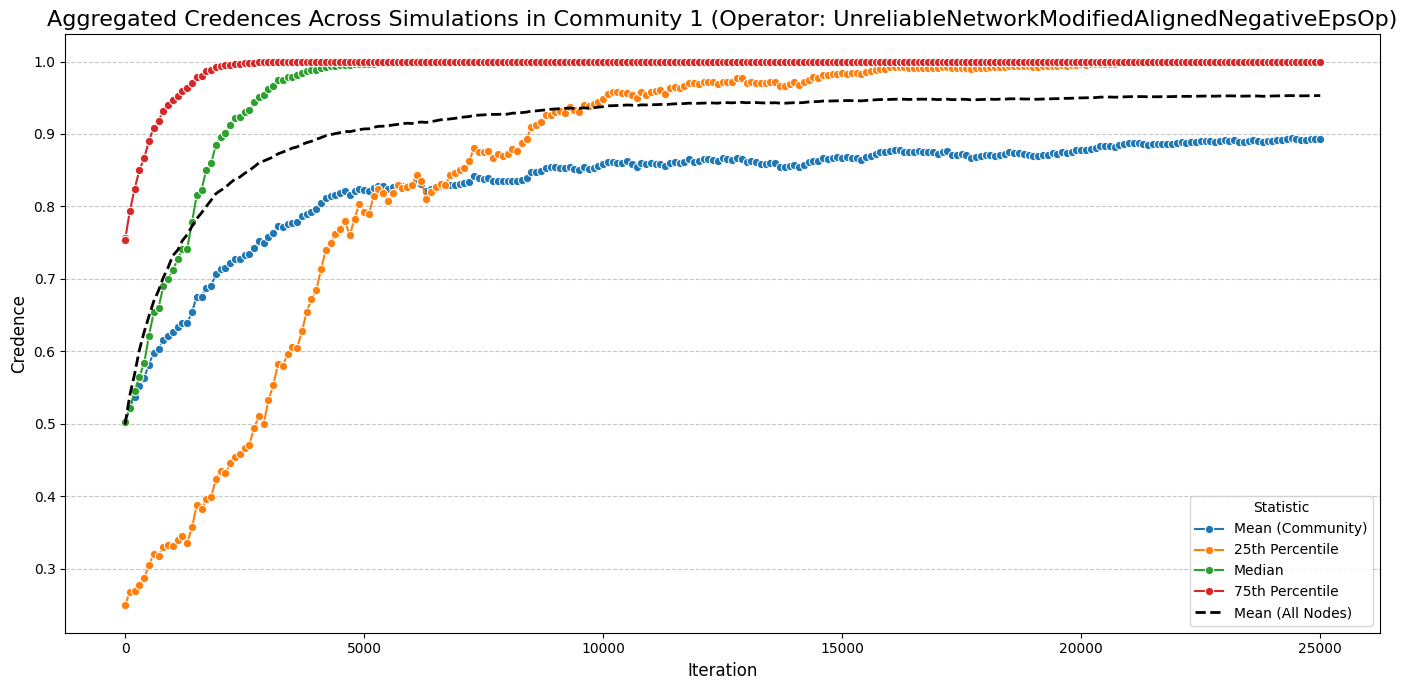

CPU times: user 1min, sys: 1min 45s, total: 2min 46s
Wall time: 9min 5s


In [20]:
%%time

# Extract nodes for the interested communities from lp_communities_df
for id in interested_communities:
    print(f"For the community id {id}")
    filtered_communities_df = lp_communities_df[lp_communities_df['lp_community_id']==id]
    # Get the list of nodes for each community in interested_communities
    filtered_nodes = filtered_communities_df['node'].tolist()
    # Filter beliefs DataFrame to include only rows with these nodes
    community_filtered_beliefs = beliefs[beliefs['node'].isin(filtered_nodes)]

    visualize_across_sims(community_filtered_beliefs)
    
    title = f"Aggregated Credences Across Simulations in Community {id}"
    visualize_across_sims_by_op(community_filtered_beliefs, title)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def credence_over_iterations_visualization(beliefs, lp_communities_df, sim_id, statistic='mean'):
    """
    Visualizes credences over iterations for multiple communities and the overall graph.
    """
    # Define aggregation function
    agg_func = {
        'mean': np.mean,
        'median': np.median,
        '25th_percentile': lambda x: np.percentile(x, 25),
        '75th_percentile': lambda x: np.percentile(x, 75)
    }[statistic]
    
    # Filter beliefs for the selected simulation
    single_sim_beliefs = beliefs[beliefs['sim'] == sim_id]
    
    # Prepare figure
    plt.figure(figsize=(12, 6))
    
    # Compute and plot credences for each community over iterations
    for community_id in lp_communities_df['lp_community_id'].unique():
        community_nodes = lp_communities_df[lp_communities_df['lp_community_id'] == community_id]['node']
        community_beliefs = single_sim_beliefs[single_sim_beliefs['node'].isin(community_nodes)]
        
        if not community_beliefs.empty:
            time_series = community_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
            sns.lineplot(x=time_series.index, y=time_series.values, label=f'Community {community_id}')
    
    # Compute and plot overall graph statistic over iterations
    overall_time_series = single_sim_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
    sns.lineplot(x=overall_time_series.index, y=overall_time_series.values, color='black', linestyle='--', label='Graph-wide Statistic')
    
    # Customize plot
    plt.title(f'{statistic.capitalize()} Credences Over Iterations (Simulation {sim_id})')
    plt.xlabel('Iteration')
    plt.ylabel('Credence')
    plt.xlim(0, 25000)  # Show full range of iterations
    plt.legend()
    plt.grid(True)
    plt.show()


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_66949/2936199314.py:29: FutureWarning: The provided callable <function mean at 0x120be9280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  time_series = community_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_66949/2936199314.py:29: FutureWarning: The provided callable <function mean at 0x120be9280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  time_series = community_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_66949/2936199314.py:29: FutureWarning: The provided callable <function mean at 0x120be9280> is currently using SeriesGroupBy.mean. In a

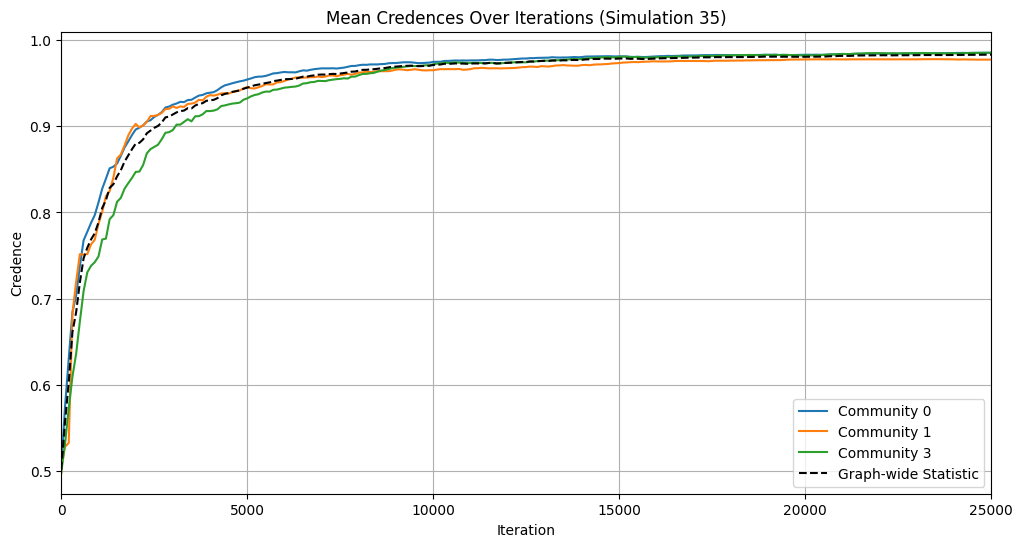

In [21]:
# Example usage:
credence_over_iterations_visualization(beliefs, lp_communities_df, sim_id=35, statistic='mean')

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def across_simulations_visualization(beliefs, lp_communities_df, operator, statistic='mean', agg_across_sims='mean'):
    """
    Aggregated visualization of credences over iterations across simulations for a given operator.
    """
    
    # Define aggregation functions
    agg_func = {
        'mean': np.mean,
        'median': np.median,
        '25th_percentile': lambda x: np.percentile(x, 25),
        '75th_percentile': lambda x: np.percentile(x, 75)
    }[statistic]
    
    agg_across_func = {
        'mean': np.mean,
        'median': np.median,
        '25th_percentile': lambda x: np.percentile(x, 25),
        '75th_percentile': lambda x: np.percentile(x, 75)
    }[agg_across_sims]
    
    op_sims = beliefs[beliefs['op'] == operator]
    
    # Initialize storage for iteration-based stats
    community_iteration_stats = {cid: {} for cid in lp_communities_df['lp_community_id'].unique()}
    graph_iteration_stats = {}
    
    for sim_id in op_sims['sim'].unique():
        sim_beliefs = op_sims[op_sims['sim'] == sim_id]
        
        for community_id in community_iteration_stats.keys():
            community_nodes = lp_communities_df[lp_communities_df['lp_community_id'] == community_id]['node']
            community_beliefs = sim_beliefs[sim_beliefs['node'].isin(community_nodes)]
            
            if not community_beliefs.empty:
                time_series = community_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
                for iteration, value in time_series.items():
                    community_iteration_stats[community_id].setdefault(iteration, []).append(value)
        
        # Overall graph statistic per iteration
        graph_time_series = sim_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
        for iteration, value in graph_time_series.items():
            graph_iteration_stats.setdefault(iteration, []).append(value)
    
    # Aggregate across simulations
    final_community_stats = {
        cid: {iteration: agg_across_func(vals) for iteration, vals in iterations.items()}
        for cid, iterations in community_iteration_stats.items()
    }
    final_graph_stats = {iteration: agg_across_func(vals) for iteration, vals in graph_iteration_stats.items()}
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    for community_id, stats in final_community_stats.items():
        sns.lineplot(x=list(stats.keys()), y=list(stats.values()), label=f'Community {community_id}')
    
    sns.lineplot(x=list(final_graph_stats.keys()), y=list(final_graph_stats.values()), color='black', linestyle='--', label='Graph-wide Statistic')
    
    plt.title(f'{statistic.capitalize()} Credences Over Iterations Across Simulations ({operator})')
    plt.xlabel('Iteration')
    plt.ylabel('Credence')
    plt.xlim(0, 25000)  # Show full iteration range
    plt.legend()
    plt.grid(True)
    plt.show()


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_66949/3073443926.py:39: FutureWarning: The provided callable <function mean at 0x120be9280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  time_series = community_beliefs.groupby('iteration')['beliefs'].agg(agg_func)
/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_66949/3073443926.py:44: FutureWarning: The provided callable <function mean at 0x120be9280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  graph_time_series = sim_beliefs.groupby('iteration')['beliefs'].agg(agg_func)


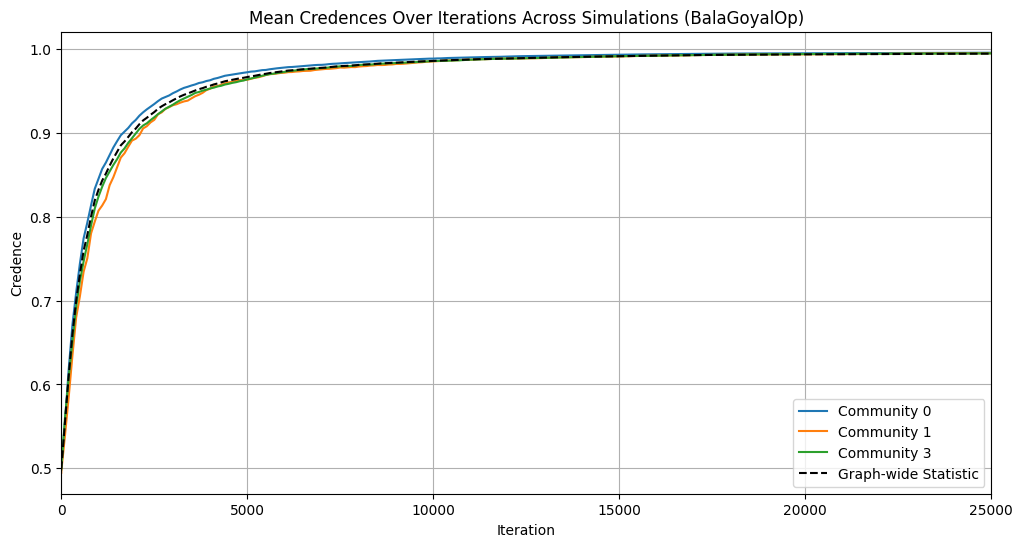

In [23]:
across_simulations_visualization(beliefs, lp_communities_df, operator='BalaGoyalOp', statistic='mean', agg_across_sims='mean')